# Preparation（must run)

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import Counter
import pickle

from sklearn import preprocessing
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE  # not available in sklearn 0.24.2
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,confusion_matrix

# from sklearn.feature_selection import SequentialFeatureSelector => not available in sklearn 0.22.2
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import os

import warnings   # to disable warning
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip i

## Methods to use

In [2]:
# for plotting confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="gray" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="gray" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# method to split the dataset into train and test sets
def split_dataset_tr_te(X,y,test_percentage=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, stratify = y)
    
    # verify the class distribution
    print("class 0:1 in y is       : {}:{}".format(Counter(list(y))[0]/y.shape[0], 1-Counter(list(y))[0]/y.shape[0]))
    print("class 0:1 in y_train is : {}:{}".format(Counter(list(y_train))[0]/y_train.shape[0], 1-Counter(list(y_train))[0]/y_train.shape[0]))
    print("class 0:1 in y_test is  : {}:{}".format(Counter(list(y_test))[0]/y_test.shape[0], 1-Counter(list(y_test))[0]/y_test.shape[0]))
    print()
    
    return X_train, X_test, y_train, y_test

# method to train models
def train_model(X_train,y_train,X_test,y_test,save_path = "./",data_type="le_smote",model_type='dt'):
    # save the validation accuracy of each fold
    fold_acc = []
    fold_model = []

    time_st = time.time()

    skf = StratifiedKFold(n_splits=5)
    skf_tr_va_sets = skf.split(X_train, y_train)

    print("Training")
    print("-"*80)

    # loop through each fold
    for idx_f, (idx_tr, idx_va) in enumerate(skf_tr_va_sets):
        # tr_X = X_train.iloc[idx_tr]
        # tr_y = y_train.iloc[idx_tr]
        # va_X = X_train.iloc[idx_va]
        # va_y = y_train.iloc[idx_va]
        tr_X = X_train[idx_tr]
        tr_y = y_train[idx_tr]
        va_X = X_train[idx_va]
        va_y = y_train[idx_va]

        if model_type == 'dt':
            model = tree.DecisionTreeClassifier(max_depth=None)
        elif model_type == 'rf':
            model = RandomForestClassifier(max_depth=None, random_state=0)
        elif model_type == 'knn':
            model = KNeighborsClassifier(n_neighbors=3)
        elif model_type == 'nb':
            model = MultinomialNB()
        elif model_type == 'lr':
            model = LogisticRegression(random_state=0)
        elif model_type == 'lda':
            model = LinearDiscriminantAnalysis()
        elif model_type == 'qda':
            model = QDA()
        elif model_type == 'svm':
            model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        elif model_type == 'mlp':
            model = Sequential()
            model.add(Dense(32, input_dim = tr_X.shape[1], activation='relu', kernel_initializer='he_normal'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(tr_X, tr_y, 
                                validation_data = (va_X, va_y), 
                                epochs=1000, 
                                batch_size=256,
                                verbose=0) 
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('fold {} - accuracy'.format(idx_f+1))
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('fold {} - loss'.format(idx_f+1))
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()  

        elif model_type == 'nn':
            model = Sequential()
            model.add(Dense(32, input_dim = tr_X.shape[1], activation='relu'))
            model.add(Dense(16, activation='relu'))
            model.add(Dense(8, activation='relu'))
            model.add(Dense(4, activation='relu'))
            model.add(Dense(2, activation='softmax'))
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(tr_X, tr_y, 
                                validation_data = (va_X, va_y), 
                                epochs=1000, 
                                batch_size=256,
                                verbose=0) 
            # list all data in history
            # print(history.history.keys())
            # summarize history for accuracy
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('fold {} - accuracy'.format(idx_f+1))
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('fold {} - loss'.format(idx_f+1))
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()    
        
        if model_type not in ['mlp','nn']:
            model = model.fit(tr_X, tr_y)
        va_y_pred = model.predict(va_X)
        # print(va_y_pred)
        if model_type == 'mlp':
            va_y_pred[va_y_pred>=0.5] = 1
            va_y_pred[va_y_pred<0.5] = 0
        elif model_type == 'nn':
            va_y_pred = [np.argmax(y_p) for y_p in va_y_pred]
        
        fold_acc.append(accuracy_score(va_y, va_y_pred))
        fold_model.append(model)

    avg_acc = sum(fold_acc)/len(fold_acc)
    abs_acc = [abs(_-avg_acc) for _ in fold_acc]
    print("Fold accuracy: {}\nAverage accuracy: {}\nSelected Model accuracy: {}".format(fold_acc, avg_acc, fold_acc[abs_acc.index(min(abs_acc))]))

    # save the model
    model_to_save = fold_model[abs_acc.index(min(abs_acc))]
    if model_type not in ['mlp','nn']:    # save_path = "./",data_type="le_smote",model_type='dt'
      model_path = save_path + "model_" + data_type + "_" + model_type + ".pkl"
      with open(model_path, 'wb') as file:
        pickle.dump(model_to_save, file)
    else:
      model_path = save_path + "model_" + data_type + "_" + model_type + ".h5"
      model_to_save.save(model_path)
    print("\nModel saved at {}\n".format(model_path))

    print("Training time (sec): {:0.9f}\n".format(time.time()-time_st))

    print("Testing")
    print("-"*80)
    # load and test the model

    if model_type not in ['mlp','nn']:
      with open(model_path, 'rb') as file:
        model = pickle.load(file)
    else:
      model = load_model(model_path)
    print("\nModel loaded from {}\n".format(model_path))  
    y_test_pred = model.predict(X_test)
    if model_type == 'mlp':
        y_test_pred[y_test_pred>=0.5] = 1
        y_test_pred[y_test_pred<0.5] = 0
        y_test_pred = y_test_pred.astype(np.uint8)
    elif model_type == 'nn':
        y_test_pred = [np.argmax(y_p) for y_p in y_test_pred]

    # y_true = list(y_test.iloc[:,0])
    y_true = list(y_test)
    if model_type not in ['mlp','nn']:
        y_test_pred = y_test_pred.tolist()
    elif model_type == 'mlp':
        y_test_pred = y_test_pred.flatten().tolist()

    # save the true and prediction lists
    np.save(save_path + "true_" + data_type + "_" + model_type + ".npy",y_true)
    print(save_path + "true_" + data_type + "_" + model_type + ".npy saved.")
    np.save(save_path + "pred_" + data_type + "_" + model_type + ".npy",y_test_pred)
    print(save_path + "pred_" + data_type + "_" + model_type + ".npy saved.")

    print("True       : {} ...".format(y_true[0:20]))
    print("Prediction : {} ...".format(y_test_pred[0:20]))
    
    print("Accuracy score             :",accuracy_score(y_true, y_test_pred))
    print("F1-score                   :",f1_score(y_true, y_test_pred))
    print("Precision score            :",precision_score(y_true, y_test_pred))
    print("Recall score               :",recall_score(y_true, y_test_pred))
    print("Auc score                  :",roc_auc_score(y_true, y_test_pred))
    print("Classification report      :\n",classification_report(y_true, y_test_pred))
    print("Confusion Matrix           :\n",confusion_matrix(y_true, y_test_pred))

    metric_list = [accuracy_score(y_true, y_test_pred),
                    f1_score(y_true, y_test_pred),
                    precision_score(y_true, y_test_pred),
                    recall_score(y_true, y_test_pred),
                    confusion_matrix(y_true, y_test_pred).item((0,0)),
                    confusion_matrix(y_true, y_test_pred).item((0,1)),
                    confusion_matrix(y_true, y_test_pred).item((1,0)),
                    confusion_matrix(y_true, y_test_pred).item((1,1))]

    # save the metrics for the testing result
    np.save(save_path + "metric_" + data_type + "_" + model_type + ".npy",metric_list)
    print(save_path + "metric_" + data_type + "_" + model_type + ".npy saved.")

    # plot confusion matrix
    cm = confusion_matrix(y_true, y_test_pred)
    plot_confusion_matrix(cm, normalize = True, target_names = ["not readmitted","readmitted"], title = "Confusion Matrix")


# Data Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Strategy

In [ ]:
# each attribute will be analyzed below:
"""
encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,
time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,
number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,
metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,
pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,
glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,
change,diabetesMed,readmitted
"""

# not related to label, attribute to be deleted
"""
encounter_id: (numeric)
"""

# not related to label, attribute to be deleted
"""
patient_nbr: (numeric)
"""

# 2% missing instances to be deleted
"""
race: (nominal)
        Caucasian, Asian, African American, Hispanic, and other
=> onehot: 5 columns        
"""

# 
"""
gender: (nominal) 
        male, female, and unknown/invalid
=> onehot: 3 columns        
"""

# 
"""
age: (nominal) 
        [0,10), [10,20), ..., [90,100)
=> onehot: 10 columns        
"""

# 97% missing, attribute to be deleted
"""
weight: (numeric) 
"""

# combine attribute values 5,6,8
"""
admission_type_id: (nominal) 
        1,Emergency; 2,Urgent; 3,Elective; 4,Newborn; 5,Not Available; 6,NULL; 7,Trauma Center; 8,Not Mapped
=> onehot: 6 columns
"""

# combine attribute values (home)1,6,8;(hospital)2,3,4,5,7,9,10,12,15,16,17,22,23,24,27,28,29,30;(not known)18,25,26,
# remove instances with attribute values (expired) 11,13,14,19,20,21,
"""
discharge_disposition_id: (nominal)
1,Discharged to home
2,Discharged/transferred to another short term hospital
3,Discharged/transferred to SNF
4,Discharged/transferred to ICF
5,Discharged/transferred to another type of inpatient care institution
6,Discharged/transferred to home with home health service
7,Left AMA
8,Discharged/transferred to home under care of Home IV provider
9,Admitted as an inpatient to this hospital
10,Neonate discharged to another hospital for neonatal aftercare
11,Expired
12,Still patient or expected to return for outpatient services
13,Hospice / home
14,Hospice / medical facility
15,Discharged/transferred within this institution to Medicare approved swing bed
16,Discharged/transferred/referred another institution for outpatient services
17,Discharged/transferred/referred to this institution for outpatient services
18,NULL
19,"Expired at home. Medicaid only, hospice."
20,"Expired in a medical facility. Medicaid only, hospice."
21,"Expired, place unknown. Medicaid only, hospice."
22,Discharged/transferred to another rehab fac including rehab units of a hospital .
23,Discharged/transferred to a long term care hospital.
24,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25,Not Mapped
26,Unknown/Invalid
27,Discharged/transferred to a federal health care facility.
28,Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29,Discharged/transferred to a Critical Access Hospital (CAH).
30,Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
=> onehot: 3 columns
"""

# combine attribute values (referral)1,2,3,8,18,19;(hospital)4,5,6,7,10,22,25,26;(not known)9,15,17,20,21;
                        # (delivery)11,12,13,14,23,24;
"""
admission_source_id: (nominal)
1, Physician Referral
2, Clinic Referral
3, HMO Referral
4, Transfer from a hospital
5, Transfer from a Skilled Nursing Facility (SNF)
6, Transfer from another health care facility
7, Emergency Room
8, Court/Law Enforcement
9, Not Available
10, Transfer from critial access hospital
11, Normal Delivery
12, Premature Delivery
13, Sick Baby
14, Extramural Birth
15, Not Available
17, NULL
18, Transfer From Another Home Health Agency
19, Readmission to Same Home Health Agency
20, Not Mapped
21, Unknown/Invalid
22, Transfer from hospital inpt/same fac reslt in a sep claim
23, Born inside this hospital
24, Born outside this hospital
25, Transfer from Ambulatory Surgery Center
26, Transfer from Hospice
=> onehot: 4 columns
"""

# 
"""
time_in_hospital: (numeric) 
=> non-onehot: 1 columns
"""

# 52% missing, attribute to be deleted
"""
payer_code: (nominal) 
"""

# 53% missing, attribute to be deleted
"""
medical_specialty: (nominal) 
"""

# 
"""
num_lab_procedures: (numeric) 
=> non-onehot: 1 columns
"""

# 
"""
num_procedures: (numeric) 
=> non-onehot: 1 columns
"""

# 
"""
num_medications: (numeric) 
=> non-onehot: 1 columns
"""

# 
"""
number_outpatient: (numeric) 
=> non-onehot: 1 columns
"""

# 
"""
number_emergency: (numeric) 
=> non-onehot: 1 columns
"""

# 
"""
number_inpatient: (numeric) 
=> non-onehot: 1 columns
"""

# ?
"""
diag_1: (nominal) 
"""

# ?
"""
diag_2: (nominal) 
"""

# 1% missing, instances to delete
"""
diag_3: (nominal) 
"""

# 
"""
number_diagnoses: (numeric) 
=> non-onehot: 1 columns
"""

# ?
"""
max_glu_serum: (nominal) 
        >200,>300,normal,none
=> onehot: 4 columns        
"""

# ?
"""
A1Cresult: (nominal) 
        >8,>7,normal,none
=> onehot: 4 columns        
"""

# ?
"""
change: (nominal) 
        change,no change
=> onehot: 2 columns        
"""

# ?
"""
diabetesMed: (nominal) 
        yes,no
=> onehot: 2 columns        
"""

# 
"""
readmitted: (nominal) 
        <30,>30,no
=> onehot: 3 columns        
"""

# ============= 23 medication usage =================
"""
metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,
pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,
glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
: (nominal)
        up,down,steady,no
=> onehot: 23*4=92 columns        
"""

'\nmetformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,\npioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,\nglyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone\n: (nominal)\n        up,down,steady,no\n=> onehot: 23*4=92 columns        \n'

## Load Data (run from here)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/diabetic_data.csv')

print("The size of the original dataset: {}".format(dataset.shape))
print()
print("The attributes are: ", dataset.columns.tolist())

# print("The first 5 records:\n",dataset.head(5))
# print("The last 5 records:\n",dataset[-5:])
dataset.head(5)

The size of the original dataset: (101766, 50)

The attributes are:  ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Remove instances or features

In [ ]:
# remove the instances of non-diabetes with none of "diag_1", "diag_2", "diag_3" being 250.x
lst0 = dataset.index.tolist()      # indices for instances 0~101766
# print(len(lst0),"\n",lst0[0:10])
lst1 = dataset.index[dataset["diag_1"].str.contains("250")].tolist()  # indices for instances with "diag_1" being 250.x
# print(len(lst1),"\n",lst1[0:10])
lst2 = dataset.index[dataset["diag_2"].str.contains("250")].tolist()  
# print(len(lst2),"\n",lst2[0:10])
lst3 = dataset.index[dataset["diag_3"].str.contains("250")].tolist()  
# print(len(lst3),"\n",lst3[0:10])

diag_1_non_250 = set(lst0) - set(lst1) # indices for instances with "diag_1" not being 250.x
diag_2_non_250 = set(lst0) - set(lst2)
diag_3_non_250 = set(lst0) - set(lst3)

diag_non_250 = diag_1_non_250 & diag_2_non_250 & diag_3_non_250  # indices for instances with none "diag" being 250.x

print("{} instances without 'diag' being 250.x to be removed. Indices are:\n {}..."
      .format(len(diag_non_250), list(diag_non_250)[0:10]))

row_to_keep = list(set(lst0) - diag_non_250) # keep the instances with any "diag" being 250.x
dataset_df = dataset.iloc[row_to_keep]

print("The size of the dataset: {}".format(dataset_df.shape))
print("Before removing non-diabetes records, the head 10 instances are:\n {}".format(dataset[0:10][['diag_1','diag_2','diag_3']]))
print("After removing non-diabetes records, the head 10 instances are:\n {}".format(dataset_df[0:10][['diag_1','diag_2','diag_3']]))

63742 instances without 'diag' being 250.x to be removed. Indices are:
 [6, 8, 9, 11, 13, 14, 15, 16, 18, 19]...
The size of the dataset: (38024, 50)
Before removing non-diabetes records, the head 10 instances are:
    diag_1  diag_2 diag_3
0  250.83       ?      ?
1     276  250.01    255
2     648     250    V27
3       8  250.43    403
4     197     157    250
5     414     411    250
6     414     411    V45
7     428     492    250
8     398     427     38
9     434     198    486
After removing non-diabetes records, the head 10 instances are:
     diag_1  diag_2 diag_3
0   250.83       ?      ?
1      276  250.01    255
2      648     250    V27
3        8  250.43    403
4      197     157    250
5      414     411    250
7      428     492    250
10   250.7     403    996
12     428  250.43  250.6
17     682     174    250


In [ ]:
# remove the duplicated instances with the same "patient_nbr"
patient_nbr_cnt = Counter(dataset_df['patient_nbr'])
# print(patient_nbr_cnt)

patient_nbr_with_multiple_record = [nbr for nbr in patient_nbr_cnt if patient_nbr_cnt[nbr] > 1]
print("Patient numbers with duplicated multiple records: {}\n{}...".format(len(patient_nbr_with_multiple_record),patient_nbr_with_multiple_record[0:100]))
print()

sample_nbr = patient_nbr_with_multiple_record[0]
print("Records with the sample patient number before removing:\n {}".format(dataset_df[dataset_df['patient_nbr'] == sample_nbr]['patient_nbr']))
print()

# for each duplicated patient number, obtain the list of row indices
for nbr in patient_nbr_with_multiple_record:
    nbr_idx = dataset_df.index[dataset_df['patient_nbr']==nbr]
    dataset_df = dataset_df.drop(nbr_idx[1:])

print("Verify the removing.")
patient_nbr_cnt = Counter(dataset_df['patient_nbr'])
patient_nbr_with_multiple_record = [nbr for nbr in patient_nbr_cnt if patient_nbr_cnt[nbr] > 1]
print("Patient numbers with duplicated multiple records: {}\n{}...".format(len(patient_nbr_with_multiple_record),patient_nbr_with_multiple_record[0:100]))
print()

print("Records with the sample patient number after removing:\n {}".format(dataset_df[dataset_df['patient_nbr'] == sample_nbr]['patient_nbr']))

print("The size of the dataset: {}".format(dataset_df.shape))

Patient numbers with duplicated multiple records: 4339
[85504905, 115196778, 41606064, 80845353, 63023292, 112002975, 63754317, 101707335, 720936, 1719279, 5041602, 276606, 53612379, 5287950, 608841, 90460242, 981198, 708741, 1427400, 1451637, 279009, 2283327, 634689, 105589584, 1160226, 8320608, 492012, 924174, 284400, 4030317, 3094443, 108387207, 567018, 277065, 419832, 1217313, 481788, 1802943, 5832918, 2486844, 81353088, 2579427, 669393, 554472, 4582233, 71235666, 1211985, 1697409, 2923146, 5877477, 4190778, 6325848, 20295, 1660932, 68029074, 5990040, 4856382, 602604, 48573, 4893183, 40158, 45144, 352377, 3467412, 70269183, 2892654, 522342, 1791090, 707769, 3778047, 4065975, 6884595, 5973228, 3344895, 4161582, 300825, 3628350, 5521167, 4309191, 1601532, 9083610, 20733057, 767061, 23031225, 5150925, 2526498, 1332981, 2535174, 9395991, 838854, 400500, 633906, 1723572, 6656679, 4103964, 8325099, 1061811, 4420413, 89515035, 81255195]...

Records with the sample patient number before re

In [ ]:
# drop the attribute columns 
column_to_drop = []
column_to_drop += ['encounter_id', 'patient_nbr'] # not related to "readmitted"
column_to_drop += ['weight', 'payer_code', 'medical_specialty'] # too many missing values
column_to_keep = dataset_df.columns.tolist()
for c in column_to_drop:
    column_to_keep.remove(c)
dataset_df = dataset_df[column_to_keep]
print("Drop the attribute columns of: \n{}".format(column_to_drop))
print()
print("The size of the  dataset: {}".format(dataset_df.shape))
print()
print("The remained attributes are: \n{}".format(dataset_df.columns.tolist()))

Drop the attribute columns of: 
['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']

The size of the  dataset: (31188, 45)

The remained attributes are: 
['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [ ]:
row_to_keep = (dataset_df['race']!='?')   # remove instances which have missing value for 'race', 2%
dataset_df = dataset_df[row_to_keep]
row_to_keep = (dataset_df['diag_3']!='?') # remove instances which have missing value for 'diag_3', 1%
dataset_df = dataset_df[row_to_keep]

# remove the instances with "discharge_disposition" being "hospice" that can't be readmitted
discharge_disposition_id_hospice = [11,13,14,19,20,21]
discharge_disposition_id_list = list(dataset_df['discharge_disposition_id'])
for id in list(dataset_df['discharge_disposition_id']):
    if id in discharge_disposition_id_hospice:
        discharge_disposition_id_list.remove(id)
row_to_keep = dataset_df['discharge_disposition_id'].isin(discharge_disposition_id_list)
dataset_df = dataset_df[row_to_keep]

print("The size of the  dataset: {}".format(dataset_df.shape))
print()
print("The attributes are: ", dataset_df.columns.tolist())
print()

The size of the  dataset: (29002, 45)

The attributes are:  ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']



In [ ]:
# for the nominal attributes, count the occurrences
column_nominal = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                  'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 
                  'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                  'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
                  'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
                  'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 
                  'change', 'diabetesMed', 'readmitted']
for c in column_nominal:
    print("{}:\n{}".format(c, Counter(dataset_df[c])))

race:
Counter({'Caucasian': 21267, 'AfricanAmerican': 6300, 'Hispanic': 749, 'Other': 504, 'Asian': 182})
gender:
Counter({'Female': 15521, 'Male': 13481})
age:
Counter({'[60-70)': 6401, '[70-80)': 6324, '[50-60)': 5862, '[40-50)': 3699, '[80-90)': 3423, '[30-40)': 1663, '[20-30)': 766, '[90-100)': 494, '[10-20)': 310, '[0-10)': 60})
admission_type_id:
Counter({1: 14666, 3: 5901, 2: 5056, 6: 1979, 5: 1236, 8: 158, 4: 4, 7: 2})
discharge_disposition_id:
Counter({1: 19483, 6: 3242, 3: 2735, 18: 1241, 22: 524, 2: 464, 25: 372, 5: 370, 7: 202, 4: 178, 23: 83, 8: 41, 28: 30, 15: 14, 17: 7, 10: 5, 24: 4, 16: 3, 9: 3, 27: 1})
admission_source_id:
Counter({7: 15616, 1: 9354, 17: 1928, 4: 769, 6: 698, 2: 343, 5: 138, 3: 70, 20: 60, 9: 20, 8: 5, 10: 1})
diag_1:
Counter({'414': 1813, '786': 1483, '250.8': 1243, '428': 1178, '715': 960, '486': 783, '410': 764, '682': 741, '250.6': 709, '434': 635, '250.7': 604, '491': 580, '427': 576, '780': 518, '250.02': 498, '250.13': 404, '276': 403, '493': 37

In [ ]:
row_to_keep = (dataset_df['diag_1']!='?') # remove instances which have missing value for 'diag_1', found by Counter
dataset_df = dataset_df[row_to_keep]
row_to_keep = (dataset_df['diag_2']!='?') # remove instances which have missing value for 'diag_2', found by Counter
dataset_df = dataset_df[row_to_keep]

# drop the attribute columns with values being too skewed
column_to_drop = []
column_to_drop += ['acetohexamide', 'tolbutamide', 'troglitazone', 
                   'tolazamide', 'examide', 'citoglipton', 'glipizide-metformin', 
                   'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'] 

column_to_keep = dataset_df.columns.tolist()
for c in column_to_drop:
    column_to_keep.remove(c)
dataset_df = dataset_df[column_to_keep]
print("Drop the attribute columns of {}".format(column_to_drop))
print()
print("The size of the  dataset: {}".format(dataset_df.shape))
print()
print("The attributes are: \n {}".format(dataset_df.columns.tolist()))

Drop the attribute columns of ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

The size of the  dataset: (28979, 35)

The attributes are: 
 ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'readmitted']


## Create a feature to count the counts of diags being 250.x (diabetes)

In [ ]:
# create one column 'diag_250_cnt' to count the times of 'diag_1', 'diag_2', 'diag_3' being 250.x
dataset_df["diag_250_cnt"] = dataset_df["diag_1"].str.contains("250").astype(int) + dataset_df["diag_2"].str.contains("250").astype(int) + dataset_df["diag_3"].str.contains("250").astype(int)
print(Counter(dataset_df["diag_250_cnt"]))
dataset_df = dataset_df[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 
                         'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                         'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 
                         'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 
                         'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
                         'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 
                         'glyburide-metformin', 'change', 'diabetesMed', 'diag_250_cnt', 'readmitted']]
dataset_df.head()

Counter({1: 28551, 2: 421, 3: 7})


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,diag_250_cnt,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,1,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Yes,1,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,1,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,Steady,No,No,No,No,No,Steady,No,Ch,Yes,1,NO
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Yes,1,>30


## Combine/Replace some nominal feature values

In [ ]:
column_nominal = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                  'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 
                  'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                  'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
                  'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
                  'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 
                  'change', 'diabetesMed', 'diag_250_cnt', 'readmitted']
feature_numerical = []
feature_nominal = []
for _ in dataset_df.columns.tolist():
    if _ in column_nominal:
        feature_nominal.append(_)
    else:
        feature_numerical.append(_)

print("Numerical features: {}\n{}".format(len(feature_numerical), feature_numerical))
print()
print("Nominal features: {}\n{}".format(len(feature_nominal), feature_nominal))

dataset_df.head()

Numerical features: 8
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Nominal features: 28
['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'diag_250_cnt', 'readmitted']


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,diag_250_cnt,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,1,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Yes,1,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,1,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,Steady,No,No,No,No,No,Steady,No,Ch,Yes,1,NO
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Yes,1,>30


In [ ]:
# for each nominal attribute, if necessary, it will be replaced by other values, including the label column:

print("Combing and Replacing feature values to reduce categorical values for each feature.")

# 'race', N/A

# 'gender', N/A 

# 'age', N/A

# 'admission_type_id' 
#    => combine 5,6,8 (replace 6,8 with 5);
dataset_df.loc[dataset_df['admission_type_id'].isin([6, 8]),'admission_type_id'] = 5

#'discharge_disposition_id' 
#    => combine 1,6,8 (replace 6,8 with 1); 
dataset_df.loc[dataset_df['discharge_disposition_id'].isin([6, 8]),'discharge_disposition_id'] = 1
#    => combine 2,3,4,5,7,9,10,12,15,16,17,22,23,24,27,28,29,30 (replace 3,4,5,7,9,10,12,15,16,17,22,23,24,27,28,29,30 with 2)
dataset_df.loc[dataset_df['discharge_disposition_id'].isin([3,4,5,7,9,10,12,15,16,17,22,23,24,27,28,29,30]),'discharge_disposition_id'] = 2
#    => combine 18,25,26 (replace 25,26 with 18);
dataset_df.loc[dataset_df['discharge_disposition_id'].isin([25,26]),'discharge_disposition_id'] = 18

# 'admission_source_id'
#    => combine 1,2,3,8,18,19 (replace 2,3,8,18,19 with 1);
dataset_df.loc[dataset_df['admission_source_id'].isin([2,3,8,18,19]),'admission_source_id'] = 1
#    => combine 4,5,6,7,10,22,25,26 (replace 5,6,7,10,22,25,26 with 4);
dataset_df.loc[dataset_df['admission_source_id'].isin([5,6,7,10,22,25,26]),'admission_source_id'] = 4
#    => combine 9,15,17,20,21 (replace 15,17,20,21 with 9);
dataset_df.loc[dataset_df['admission_source_id'].isin([15,17,20,21]),'admission_source_id'] = 9
#    => combine 11,12,13,14,23,24 (replace 12,13,14,23,24 with 11);
dataset_df.loc[dataset_df['admission_source_id'].isin([12,13,14,23,24]),'admission_source_id'] = 11

#'diag_1', 'diag_2', 'diag_3'
'''
    => replace the ICD-9 codes using corresponding chapter #.
        Chapter	Code Range	Description
        1	001-139	Infectious And Parasitic Diseases
        2	140-239	Neoplasms
        3	240-279	Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
        4	280-289	Diseases Of The Blood And Blood-Forming Organs
        5	290-319	Mental Disorders
        6	320-389	Diseases Of The Nervous System And Sense Organs
        7	390-459	Diseases Of The Circulatory System
        8	460-519	Diseases Of The Respiratory System
        9	520-579	Diseases Of The Digestive System
        10	580-629	Diseases Of The Genitourinary System
        11	630-679	Complications Of Pregnancy, Childbirth, And The Puerperium
        12	680-709	Diseases Of The Skin And Subcutaneous Tissue
        13	710-739	Diseases Of The Musculoskeletal System And Connective Tissue
        14	740-759	Congenital Anomalies
        15	760-779	Certain Conditions Originating In The Perinatal Period
        16	780-799	Symptoms, Signs, And Ill-Defined Conditions
        17	800-999	Injury And Poisoning
        18	V01-V91	Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services
        19	E000-E999	Supplementary Classification Of External Causes Of Injury And Poisoning
'''
def diag_replace(x):
    if "V" in str(x):
        return 18
    elif "E" in str(x):
        return 19
    else:
        x = int(float(x))
        if x>=1 and x<=139: return 1
        elif x>=140 and x<=239: return 2
        elif x>=240 and x<=279: return 3
        elif x>=280 and x<=289: return 4
        elif x>=290 and x<=319: return 5
        elif x>=320 and x<=389: return 6
        elif x>=390 and x<=459: return 7
        elif x>=460 and x<=519: return 8
        elif x>=520 and x<=579: return 9
        elif x>=580 and x<=629: return 10
        elif x>=630 and x<=679: return 11
        elif x>=680 and x<=709: return 12
        elif x>=710 and x<=739: return 13
        elif x>=740 and x<=759: return 14
        elif x>=760 and x<=779: return 15
        elif x>=780 and x<=799: return 16
        elif x>=800 and x<=999: return 17
        
dataset_df['diag_1'] = dataset_df['diag_1'].apply(diag_replace)
dataset_df['diag_2'] = dataset_df['diag_2'].apply(diag_replace)
dataset_df['diag_3'] = dataset_df['diag_3'].apply(diag_replace)

# 'max_glu_serum'
#     => replace ">200",">300" with "abnormal"
dataset_df.loc[dataset_df['max_glu_serum'].isin([">200",">300"]),'max_glu_serum'] = "abnormal"

# 'A1Cresult'
#     => replace ">8",">7" with "abnormal"
dataset_df.loc[dataset_df['A1Cresult'].isin([">8",">7"]),'A1Cresult'] = "abnormal"

# 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
# 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin'
#     => replace "Up","Down" with "yes"
#     => replace "Steady","No" with "no"
med_lst = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
           'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin']
for med in med_lst:
    dataset_df.loc[dataset_df[med].isin(["Up","Down"]), med] = "yes"
    dataset_df.loc[dataset_df[med].isin(["Steady","No"]), med] = "no"

# 'change', N/A

# 'diabetesMed', N/A

#'diag_250_cnt', N/A

# 'readmitted'
#     => replace "<30" by "yes"
#     => replace ">30","No" by "no"
dataset_df.loc[dataset_df['readmitted'].isin(["<30"]),'readmitted'] = "yes"
dataset_df.loc[dataset_df['readmitted'].isin([">30","NO"]),'readmitted'] = "no"

print()
print("After combing and replacing:")
feature_nominal = ['race', 'gender', 'age', 
                   'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                   'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 
                   'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
                   'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 
                   'glyburide-metformin', 'change', 'diabetesMed', 'diag_250_cnt', 'readmitted']
for c in feature_nominal:
    print("{}:\n{}".format(c, Counter(dataset_df[c])))

Combing and Replacing feature values to reduce categorical values for each feature.

After combing and replacing:
race:
Counter({'Caucasian': 21249, 'AfricanAmerican': 6297, 'Hispanic': 747, 'Other': 504, 'Asian': 182})
gender:
Counter({'Female': 15511, 'Male': 13468})
age:
Counter({'[60-70)': 6391, '[70-80)': 6319, '[50-60)': 5862, '[40-50)': 3697, '[80-90)': 3418, '[30-40)': 1663, '[20-30)': 766, '[90-100)': 494, '[10-20)': 309, '[0-10)': 60})
admission_type_id:
Counter({1: 14651, 3: 5897, 2: 5052, 5: 3373, 4: 4, 7: 2})
discharge_disposition_id:
Counter({1: 22748, 2: 4618, 18: 1613})
admission_source_id:
Counter({4: 17209, 1: 9762, 9: 2008})
diag_1:
Counter({7: 7221, 3: 6450, 16: 2342, 9: 2306, 8: 2297, 13: 1967, 17: 1363, 10: 1122, 12: 887, 2: 778, 5: 688, 1: 411, 11: 352, 6: 339, 18: 228, 4: 209, 14: 19})
diag_2:
Counter({3: 12134, 7: 6855, 8: 1589, 12: 1282, 10: 1275, 16: 1147, 9: 831, 5: 663, 13: 540, 18: 513, 4: 504, 1: 367, 2: 322, 6: 321, 17: 289, 11: 169, 19: 160, 14: 18})
di

## Convert numerical data into categorical 

feature: time_in_hospital min: 1 max: 14
[(1, 5175), (2, 5693), (3, 5429), (4, 3862), (5, 2581), (6, 1782), (7, 1352), (8, 959), (9, 586), (10, 468), (11, 359), (12, 306), (13, 232), (14, 195)]


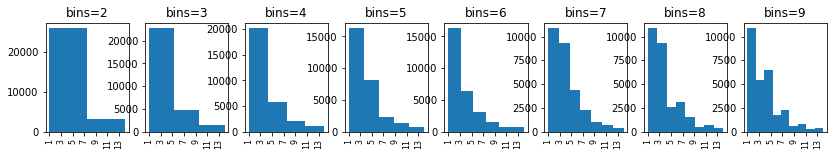

feature: num_lab_procedures min: 1 max: 118
[(1, 1079), (2, 339), (3, 206), (4, 139), (5, 108), (6, 92), (7, 132), (8, 119), (9, 282), (10, 266), (11, 173), (12, 144), (13, 124), (14, 111), (15, 109), (16, 142), (17, 200), (18, 198), (19, 303), (20, 275), (21, 238), (22, 241), (23, 296), (24, 206), (25, 302), (26, 344), (27, 263), (28, 297), (29, 416), (30, 400), (31, 434), (32, 390), (33, 391), (34, 547), (35, 626), (36, 598), (37, 612), (38, 685), (39, 640), (40, 650), (41, 601), (42, 624), (43, 851), (44, 682), (45, 661), (46, 681), (47, 618), (48, 576), (49, 553), (50, 528), (51, 527), (52, 474), (53, 500), (54, 542), (55, 507), (56, 469), (57, 477), (58, 462), (59, 415), (60, 384), (61, 430), (62, 379), (63, 378), (64, 314), (65, 292), (66, 300), (67, 278), (68, 264), (69, 257), (70, 188), (71, 182), (72, 161), (73, 153), (74, 142), (75, 114), (76, 108), (77, 108), (78, 84), (79, 72), (80, 84), (81, 65), (82, 48), (83, 44), (84, 32), (85, 39), (86, 30), (87, 15), (88, 25), (89, 23

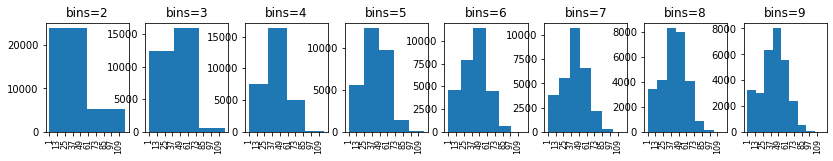

feature: num_procedures min: 0 max: 6
[(0, 13933), (1, 6114), (2, 3478), (3, 2570), (4, 968), (5, 795), (6, 1121)]


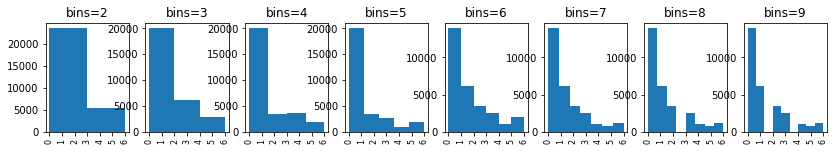

feature: num_medications min: 1 max: 67
[(1, 105), (2, 192), (3, 377), (4, 594), (5, 808), (6, 1055), (7, 1310), (8, 1559), (9, 1678), (10, 1776), (11, 1739), (12, 1909), (13, 1779), (14, 1552), (15, 1545), (16, 1478), (17, 1229), (18, 1051), (19, 979), (20, 866), (21, 766), (22, 696), (23, 556), (24, 502), (25, 446), (26, 364), (27, 313), (28, 285), (29, 227), (30, 208), (31, 149), (32, 120), (33, 108), (34, 97), (35, 88), (36, 50), (37, 56), (38, 40), (39, 40), (40, 42), (41, 26), (42, 24), (43, 21), (44, 17), (45, 16), (46, 22), (47, 16), (48, 12), (49, 12), (50, 4), (51, 7), (52, 13), (53, 11), (54, 5), (55, 5), (56, 8), (57, 4), (58, 4), (59, 3), (60, 7), (61, 4), (62, 2), (66, 1), (67, 1)]


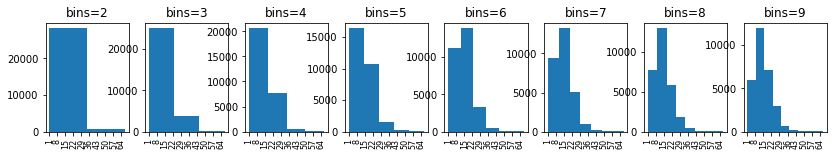

feature: number_outpatient min: 0 max: 25
[(0, 25144), (1, 2041), (2, 821), (3, 456), (4, 212), (5, 117), (6, 58), (7, 34), (8, 20), (9, 18), (10, 17), (11, 6), (12, 7), (13, 9), (14, 5), (15, 4), (16, 2), (17, 1), (20, 3), (21, 1), (23, 1), (24, 1), (25, 1)]


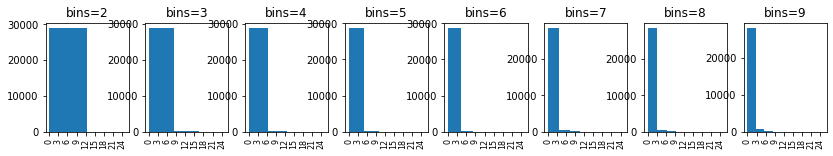

feature: number_emergency min: 0 max: 42
[(0, 26492), (1, 1787), (2, 431), (3, 134), (4, 60), (5, 31), (6, 15), (7, 12), (8, 5), (9, 3), (10, 3), (11, 1), (12, 1), (13, 1), (16, 1), (25, 1), (42, 1)]


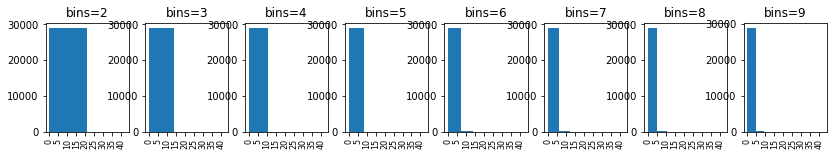

feature: number_inpatient min: 0 max: 14
[(0, 23604), (1, 3674), (2, 1068), (3, 330), (4, 147), (5, 72), (6, 44), (7, 15), (8, 6), (9, 9), (10, 2), (11, 3), (12, 4), (14, 1)]


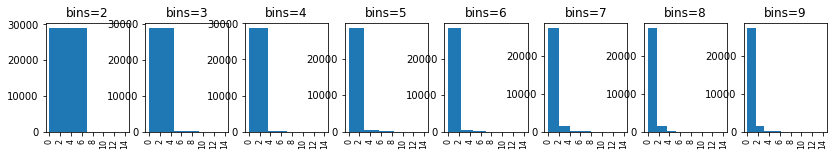

feature: number_diagnoses min: 3 max: 16
[(3, 2386), (4, 3543), (5, 5143), (6, 3885), (7, 3121), (8, 2462), (9, 8428), (10, 2), (11, 1), (12, 2), (13, 2), (14, 2), (16, 2)]


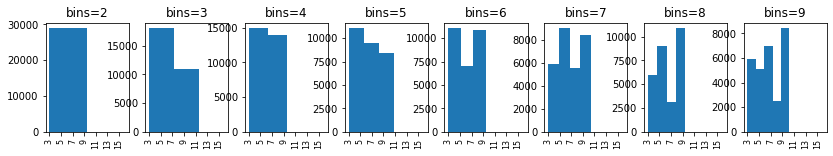

' for reference\nfor _ in range(2,10):\n        dataset_df[f_n].plot(kind=\'hist\',\n                             ax=axes[_-2],\n                             bins=_,\n                             title="bins="+str(_),\n                             xticks = range(dataset_df[f_n].min(),dataset_df[f_n].max(),int((dataset_df[f_n].max()-dataset_df[f_n].min())/10)+1))\n'

In [ ]:
# observe how the bins number influence the distribution
feature_numerical = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
for f_n in feature_numerical: 
    print("feature: {} min: {} max: {}".format(f_n,dataset_df[f_n].min(),dataset_df[f_n].max()))
    print("{}".format(sorted(Counter(dataset_df[f_n]).items())))
    
    y_value = dataset_df[f_n]
    x_value = range(dataset_df[f_n].min(),dataset_df[f_n].max()+1,int((dataset_df[f_n].max()+1-dataset_df[f_n].min())/10)+1)
    
    fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(14,2))
    
    for _ in range(2,10):
        axes[_-2].hist(y_value,bins=_)
        axes[_-2].set_title("bins="+str(_))
        axes[_-2].set_xticks(x_value)
        axes[_-2].set_xticklabels(x_value,fontsize=8,rotation=90)
        
    plt.show()
    
''' for reference
for _ in range(2,10):
        dataset_df[f_n].plot(kind='hist',
                             ax=axes[_-2],
                             bins=_,
                             title="bins="+str(_),
                             xticks = range(dataset_df[f_n].min(),dataset_df[f_n].max(),int((dataset_df[f_n].max()-dataset_df[f_n].min())/10)+1))
'''    

In [ ]:
# convert the numerical variables into categorical, creating new features by 'x_group'
dataset_df['time_in_hospital_group'] = pd.cut(dataset_df['time_in_hospital'],
                                              bins=[-1,7,dataset_df['time_in_hospital'].max()],  # allocate into 2 bins
                                              labels=["0","1"]) 
dataset_df['num_lab_procedures_group'] = pd.cut(dataset_df['num_lab_procedures'],
                                              bins=[-1,37,74,dataset_df['num_lab_procedures'].max()],  # allocate into 3 bins
                                              labels=["0","1","2"])
dataset_df['num_procedures_group'] = pd.cut(dataset_df['num_procedures'],
                                              bins=[-1,1,4,dataset_df['num_procedures'].max()],  # allocate into 3 bins
                                              labels=["0","1","2"])
dataset_df['num_medications_group'] = pd.cut(dataset_df['num_medications'],
                                              bins=[-1,18,33,dataset_df['num_medications'].max()],  # allocate into 3 bins
                                              labels=["0","1","2"])
dataset_df['number_outpatient_group'] = pd.cut(dataset_df['number_outpatient'],
                                              bins=[-1,10,dataset_df['number_outpatient'].max()],  # allocate into 2 bins
                                              labels=["0","1"])
dataset_df['number_emergency_group'] = pd.cut(dataset_df['number_emergency'],
                                              bins=[-1,10,dataset_df['number_emergency'].max()],  # allocate into 2 bins
                                              labels=["0","1"])
dataset_df['number_inpatient_group'] = pd.cut(dataset_df['number_inpatient'],
                                              bins=[-1,2,7,dataset_df['number_inpatient'].max()],  # allocate into 3 bins
                                              labels=["0","1","2"])
dataset_df['number_diagnoses_group'] = pd.cut(dataset_df['number_diagnoses'],
                                              bins=[-1,9,dataset_df['number_diagnoses'].max()],  # allocate into 2 bins
                                              labels=["0","1"])

print()
lst_group = ['time_in_hospital_group','num_lab_procedures_group','num_procedures_group','num_medications_group',
             'number_outpatient_group','number_emergency_group','number_inpatient_group','number_diagnoses_group']
print("After converting numerical variables to categorical:")
for c in lst_group:
    print("{}:\n{}".format(c, Counter(dataset_df[c])))


After converting numerical variables to categorical:
time_in_hospital_group:
Counter({'0': 25874, '1': 3105})
num_lab_procedures_group:
Counter({'1': 16825, '0': 11142, '2': 1012})
num_procedures_group:
Counter({'0': 20047, '1': 7016, '2': 1916})
num_medications_group:
Counter({'0': 21736, '1': 6585, '2': 658})
number_outpatient_group:
Counter({'0': 28938, '1': 41})
number_emergency_group:
Counter({'0': 28973, '1': 6})
number_inpatient_group:
Counter({'0': 28346, '1': 608, '2': 25})
number_diagnoses_group:
Counter({'0': 28968, '1': 11})


In [ ]:
feature_cat = ['race', 'gender', 'age', 
               'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
               'diag_1', 'diag_2', 'diag_3', 'time_in_hospital_group', 'num_lab_procedures_group',
               'num_procedures_group','num_medications_group','number_outpatient_group',
               'number_emergency_group','number_inpatient_group','number_diagnoses_group',
               'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
               'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
               'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'diag_250_cnt', 'readmitted'] 

dataset_df_cat = dataset_df[feature_cat]

print("After converting numerical variables to categorical, size: {}".format(dataset_df_cat.shape))
dataset_df_cat.sample(10)

After converting numerical variables to categorical, size: (28979, 36)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,time_in_hospital_group,num_lab_procedures_group,num_procedures_group,num_medications_group,number_outpatient_group,number_emergency_group,number_inpatient_group,number_diagnoses_group,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,diag_250_cnt,readmitted
60958,Caucasian,Male,[80-90),1,1,4,7,7,3,0,0,0,0,0,0,0,0,None,None,no,no,no,no,no,no,no,no,no,no,no,no,no,No,No,1,no
76283,Caucasian,Female,[60-70),1,1,4,7,3,3,0,0,0,0,0,0,0,0,None,None,no,no,no,no,no,no,no,no,no,no,no,no,no,No,Yes,1,no
98693,Caucasian,Male,[60-70),3,2,1,3,7,10,0,0,1,0,0,0,0,0,None,None,no,no,no,no,no,no,no,no,no,no,no,yes,no,Ch,Yes,1,no
66000,AfricanAmerican,Male,[50-60),3,1,1,3,7,12,0,1,0,1,0,0,0,0,None,None,no,no,no,no,no,no,no,no,no,no,no,yes,no,Ch,Yes,1,no
23945,Caucasian,Male,[80-90),5,1,1,17,19,3,0,0,1,0,0,0,0,0,Norm,None,no,no,no,no,no,no,no,no,no,no,no,no,no,No,No,1,no
4545,AfricanAmerican,Female,[70-80),1,1,4,7,7,3,0,1,1,0,0,0,0,0,None,None,no,no,no,no,no,no,no,no,no,no,no,no,no,No,No,1,no
69182,Hispanic,Female,[60-70),5,1,9,3,3,1,1,1,1,1,0,0,0,0,None,abnormal,no,no,no,no,no,no,no,yes,no,no,no,yes,no,Ch,Yes,1,no
25077,AfricanAmerican,Male,[70-80),3,2,4,8,8,3,1,1,0,0,0,0,0,0,None,abnormal,no,no,no,no,no,no,no,no,no,no,no,no,no,No,Yes,1,no
24138,AfricanAmerican,Male,[50-60),1,1,4,3,16,12,0,1,1,1,0,0,0,0,None,abnormal,yes,no,no,no,no,no,no,no,no,no,no,yes,no,Ch,Yes,1,no
32506,Caucasian,Female,[70-80),5,1,9,7,3,3,0,0,0,0,0,0,0,0,Norm,None,no,no,no,no,no,no,no,no,no,no,no,no,no,No,No,1,no


## Encode data by label encoding

In [ ]:
le = preprocessing.LabelEncoder()
dataset_df_cat_le = dataset_df_cat.apply(le.fit_transform)
print("After label encoding, size: {}".format(dataset_df_cat_le.shape))
dataset_df_cat_le.sample(10)

After label encoding, size: (28979, 36)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,time_in_hospital_group,num_lab_procedures_group,num_procedures_group,num_medications_group,number_outpatient_group,number_emergency_group,number_inpatient_group,number_diagnoses_group,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,diag_250_cnt,readmitted
40903,0,0,8,1,1,0,0,2,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
45616,0,0,5,1,0,0,14,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
58849,2,0,6,4,0,0,7,2,6,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
77077,2,0,7,0,1,1,6,2,7,1,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
86677,2,0,8,0,1,1,7,6,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
43889,2,0,7,1,0,1,14,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
53446,2,0,3,0,0,0,2,7,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
62935,0,1,5,4,0,0,15,6,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
66849,2,0,8,1,0,0,6,2,16,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
57854,0,0,4,1,0,0,7,4,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


## Save the label encoded dataset

In [ ]:
dataset_df_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/dataset_df.pkl"
dataset_df.to_pickle(dataset_df_path) 
dataset_df_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/dataset_df_cat_le.pkl"
dataset_df_cat_le.to_pickle(dataset_df_path) 

# Data Augmentation and One-hot encoding <font color="red">**(Run From Here to Save Time for Data Preprocessing)**</font>

## Load the label encoded dataset (run from here)

In [ ]:
dataset_df_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/dataset_df.pkl"
dataset_df = pd.read_pickle(dataset_df_path) 
dataset_df_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/dataset_df_cat_le.pkl"
dataset_df_cat_le = pd.read_pickle(dataset_df_path) 

dataset_df_cat_le = shuffle(dataset_df_cat_le)
dataset_df_cat_le_X = dataset_df_cat_le.iloc[:,0:dataset_df_cat_le.shape[1]-1]
print("dataset_df_cat_le_X has a shape of {}".format(dataset_df_cat_le_X.shape))
print("the first 5 instances:\n{}".format(dataset_df_cat_le_X.iloc[0:5,:]))
dataset_df_cat_le_y = dataset_df_cat_le.iloc[:,-1:]
print("dataset_df_cat_le_y has a shape of {}".format(dataset_df_cat_le_y.shape))
print("the first 5 instances:\n{}".format(dataset_df_cat_le_y.iloc[0:5,:]))
print()

dataset_df_cat_le_X has a shape of (28979, 35)
the first 5 instances:
       race  gender  age  ...  change  diabetesMed  diag_250_cnt
7397      2       1    6  ...       1            1             0
15376     2       0    5  ...       1            1             0
15406     2       0    6  ...       1            0             0
50858     2       0    5  ...       1            1             0
68302     0       0    2  ...       0            1             0

[5 rows x 35 columns]
dataset_df_cat_le_y has a shape of (28979, 1)
the first 5 instances:
       readmitted
7397            0
15376           1
15406           0
50858           0
68302           0



## Data Augmentation with SMOTE

In [ ]:
print("Before applying SMOTE:")
print(Counter(dataset_df['readmitted']))
print(Counter(dataset_df_cat_le_y['readmitted']))

dataset_df_cat_le_X_smote, dataset_df_cat_le_y_smote = SMOTE().fit_resample(dataset_df_cat_le_X, dataset_df_cat_le_y)

print("After applying SMOTE:")
# print(Counter(dataset_df_cat_le_y_smote['readmitted']))
print(Counter(dataset_df_cat_le_y_smote))

Before applying SMOTE:
Counter({'no': 26235, 'yes': 2744})
Counter({0: 26235, 1: 2744})
After applying SMOTE:
Counter({0: 26235, 1: 26235})


## Label Encoded Data with SMOTE - Split into train and test sets by stratified splitting

In [ ]:
dataset_df_cat_le_X_smote_train, dataset_df_cat_le_X_smote_test, dataset_df_cat_le_y_smote_train, dataset_df_cat_le_y_smote_test = split_dataset_tr_te(dataset_df_cat_le_X_smote,dataset_df_cat_le_y_smote,test_percentage=0.2)
# backup the orignial train and test features for feature selection and reduction use
# dataset_df_cat_le_X_smote_train_back = dataset_df_cat_le_X_smote_train.copy()
# dataset_df_cat_le_X_smote_test_back = dataset_df_cat_le_X_smote_test.copy()

# method to split the dataset into train and validation sets
skf = StratifiedKFold(n_splits=5)
skf_tr_va_sets = skf.split(dataset_df_cat_le_X_smote_train, dataset_df_cat_le_y_smote_train)
for idx_f, (idx_tr, idx_va) in enumerate(skf_tr_va_sets):
    # tr_X = dataset_df_cat_le_X_smote_train.iloc[idx_tr]
    # tr_y = dataset_df_cat_le_y_smote_train.iloc[idx_tr]
    # va_X = dataset_df_cat_le_X_smote_train.iloc[idx_va]
    # va_y = dataset_df_cat_le_y_smote_train.iloc[idx_va]
    tr_X = dataset_df_cat_le_X_smote_train[idx_tr]
    tr_y = dataset_df_cat_le_y_smote_train[idx_tr]
    va_X = dataset_df_cat_le_X_smote_train[idx_va]
    va_y = dataset_df_cat_le_y_smote_train[idx_va]
    print("Fold {}\ntrain set X:{} train set y: {} validation set X:{} validation set y: {}".format(idx_f,tr_X.shape,tr_y.shape,va_X.shape,va_y.shape))
    print("class 0:1 in train set y is      : {}:{}".format(Counter(list(tr_y))[0]/tr_y.shape[0], 1-Counter(list(tr_y))[0]/tr_y.shape[0]))
    print("class 0:1 in validation set y is : {}:{}".format(Counter(list(va_y))[0]/va_y.shape[0], 1-Counter(list(va_y))[0]/va_y.shape[0]))

# save the label encoded datasets
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
np.save(save_path+"dataset_df_cat_le_X_smote_train.npy",dataset_df_cat_le_X_smote_train)
np.save(save_path+"dataset_df_cat_le_y_smote_train.npy",dataset_df_cat_le_y_smote_train)
np.save(save_path+"dataset_df_cat_le_X_smote_test.npy",dataset_df_cat_le_X_smote_test)
np.save(save_path+"dataset_df_cat_le_y_smote_test.npy",dataset_df_cat_le_y_smote_test)


class 0:1 in y is       : 0.5:0.5
class 0:1 in y_train is : 0.5:0.5
class 0:1 in y_test is  : 0.5:0.5

Fold 0
train set X:(33580, 35) train set y: (33580,) validation set X:(8396, 35) validation set y: (8396,)
class 0:1 in train set y is      : 0.5:0.5
class 0:1 in validation set y is : 0.5:0.5
Fold 1
train set X:(33581, 35) train set y: (33581,) validation set X:(8395, 35) validation set y: (8395,)
class 0:1 in train set y is      : 0.4999851106280337:0.5000148893719663
class 0:1 in validation set y is : 0.5000595592614652:0.49994044073853483
Fold 2
train set X:(33581, 35) train set y: (33581,) validation set X:(8395, 35) validation set y: (8395,)
class 0:1 in train set y is      : 0.4999851106280337:0.5000148893719663
class 0:1 in validation set y is : 0.5000595592614652:0.49994044073853483
Fold 3
train set X:(33581, 35) train set y: (33581,) validation set X:(8395, 35) validation set y: (8395,)
class 0:1 in train set y is      : 0.5000148893719663:0.49998511062803375
class 0:1 in va

## Label Encoded Data with SMOTE - Convert into One-hot Encoded Data 

In [ ]:
# to avoid dimension difference between X_train and X_test after one-hot encoding, combine the two and then do one-hot encoding
dataset_df_cat_le_X_smote_train_test = np.vstack((dataset_df_cat_le_X_smote_train,dataset_df_cat_le_X_smote_test))

# Convert the feature sets into one-hot encoding 
for _ in range(dataset_df_cat_le_X_smote_train_test.shape[1]):
    col_onehot = LabelBinarizer().fit_transform(dataset_df_cat_le_X_smote_train_test[:,_])
    dataset_df_cat_ohe_X_smote_train_test = col_onehot if _==0 else np.hstack((dataset_df_cat_ohe_X_smote_train_test,col_onehot))

dataset_df_cat_ohe_X_smote_train = dataset_df_cat_ohe_X_smote_train_test[0:dataset_df_cat_le_X_smote_train.shape[0],:]
dataset_df_cat_ohe_X_smote_test = dataset_df_cat_ohe_X_smote_train_test[dataset_df_cat_le_X_smote_train.shape[0]:,:]
dataset_df_cat_ohe_y_smote_train = dataset_df_cat_le_y_smote_train
dataset_df_cat_ohe_y_smote_test = dataset_df_cat_le_y_smote_test

save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
np.save(save_path+"dataset_df_cat_ohe_X_smote_train.npy",dataset_df_cat_ohe_X_smote_train)
np.save(save_path+"dataset_df_cat_ohe_y_smote_train.npy",dataset_df_cat_ohe_y_smote_train)
np.save(save_path+"dataset_df_cat_ohe_X_smote_test.npy",dataset_df_cat_ohe_X_smote_test)
np.save(save_path+"dataset_df_cat_ohe_y_smote_test.npy",dataset_df_cat_ohe_y_smote_test)

# Label Encoded Data with SMOTE - Training and testing

## DT (run from here)

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8301572177227251, 0.8251340083382966, 0.8233472304943419, 0.8266825491363907, 0.8234663490172722]
Average accuracy: 0.8257574709418052
Selected Model accuracy: 0.8251340083382966

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_dt.pkl

Training time (sec): 0.782488823

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_dt.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_dt.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_dt.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accuracy score       

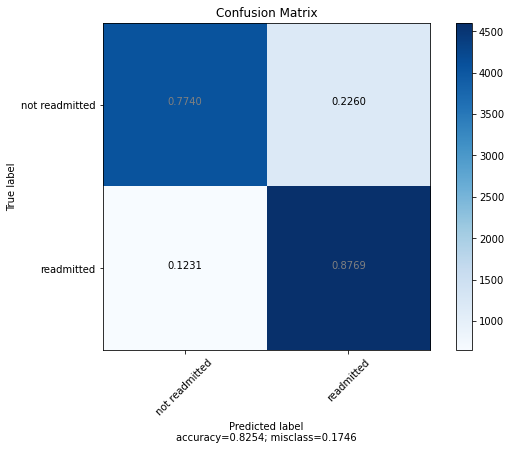

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='dt')

## RF

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8825631252977608, 0.880762358546754, 0.8795711733174508, 0.8700416914830256, 0.8783799880881477]
Average accuracy: 0.8782636673466279
Selected Model accuracy: 0.8783799880881477

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_rf.pkl

Training time (sec): 15.909461021

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_rf.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_rf.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_rf.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accuracy score       

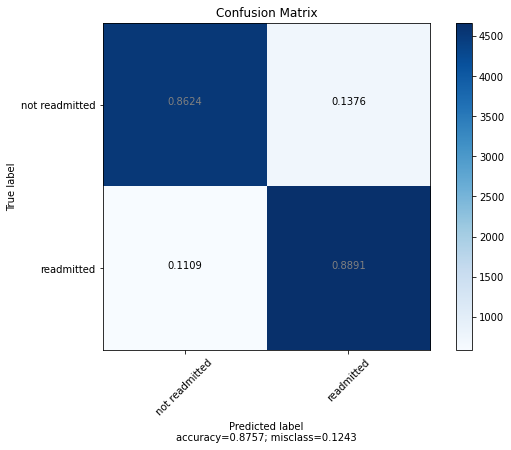

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='rf')

## KNN

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8141972367794188, 0.809410363311495, 0.8157236450268016, 0.8097677188802859, 0.8070279928528886]
Average accuracy: 0.811225391370178
Selected Model accuracy: 0.8097677188802859

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_knn.pkl

Training time (sec): 11.444244623

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_knn.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_knn.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_knn.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1] ...
Accuracy score    

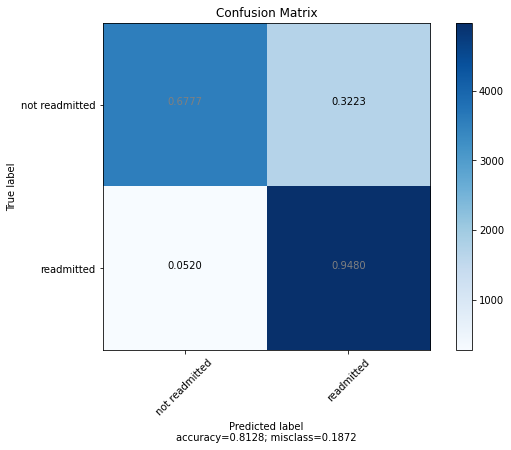

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='knn')

## NB

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.6223201524535493, 0.6201310303752233, 0.6196545562835021, 0.618106015485408, 0.6194163192376414]
Average accuracy: 0.6199256147670649
Selected Model accuracy: 0.6201310303752233

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_nb.pkl

Training time (sec): 0.155695677

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_nb.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_nb.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_nb.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accuracy score        

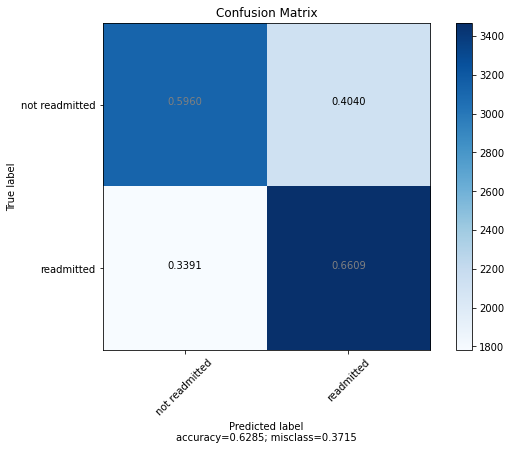

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='nb')

## LR

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.6788947117675084, 0.6767123287671233, 0.6767123287671233, 0.664919594997022, 0.6780226325193568]
Average accuracy: 0.6750523193636268
Selected Model accuracy: 0.6767123287671233

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_lr.pkl

Training time (sec): 3.048478127

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_lr.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_lr.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_lr.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1] ...
Accuracy score        

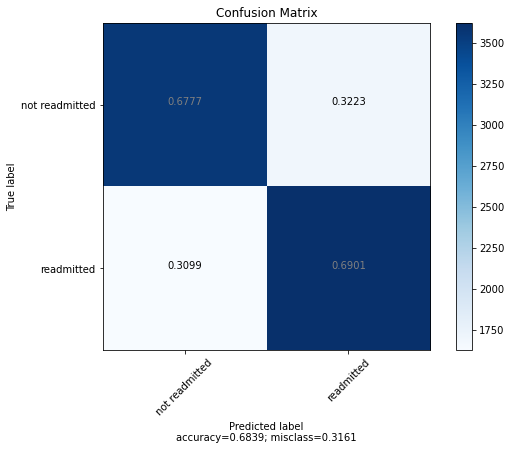

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='lr')

## LDA

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.6805621724630777, 0.6774270399047052, 0.6763549731983324, 0.6651578320428827, 0.6800476474091721]
Average accuracy: 0.675909933003634
Selected Model accuracy: 0.6763549731983324

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_lda.pkl

Training time (sec): 1.119404554

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_lda.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_lda.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_lda.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accuracy score    

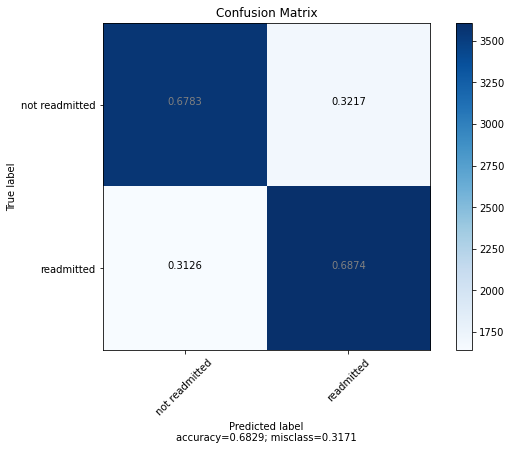

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='lda')

## QDA

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.5145307289185327, 0.5236450268016677, 0.5175699821322216, 0.5254318046456224, 0.5144729005360333]
Average accuracy: 0.5191300886068155
Selected Model accuracy: 0.5175699821322216

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_qda.pkl

Training time (sec): 0.444231510

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_qda.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_qda.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_qda.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...
Accuracy score   

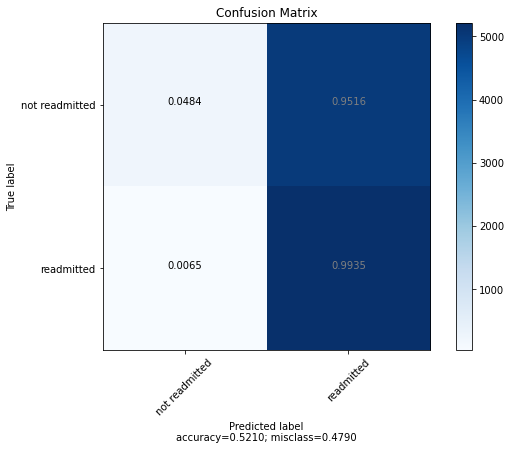

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='qda')

## SVM

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.7490471653168176, 0.7447290053603335, 0.7449672424061942, 0.7303156640857653, 0.7431804645622394]
Average accuracy: 0.7424479083462701
Selected Model accuracy: 0.7431804645622394

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_svm.pkl

Training time (sec): 409.824214697

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_svm.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_svm.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_svm.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1] ...
Accuracy score 

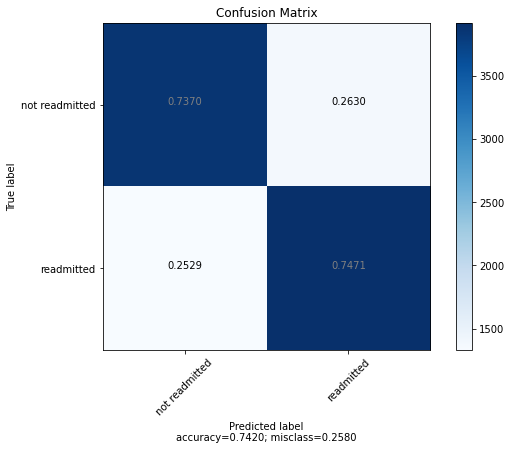

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='svm')

## MLP

Training
--------------------------------------------------------------------------------


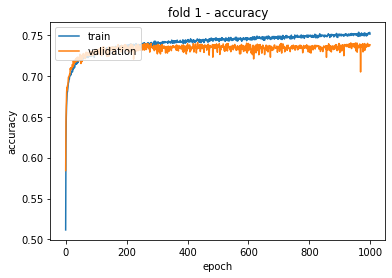

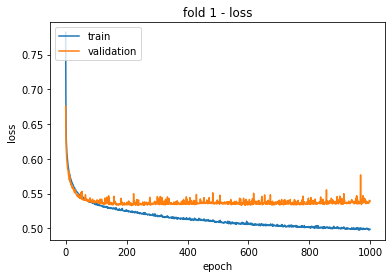

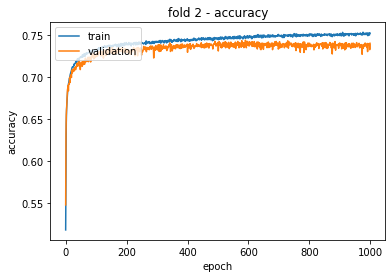

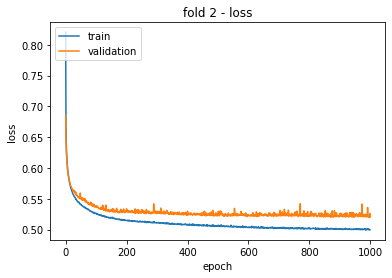

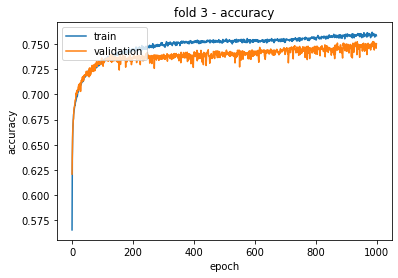

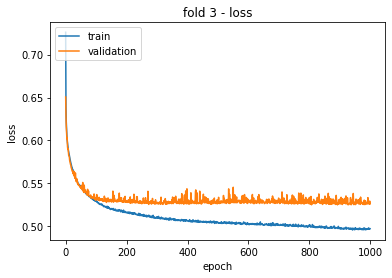

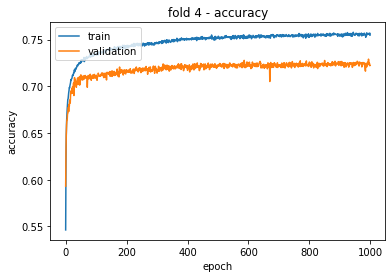

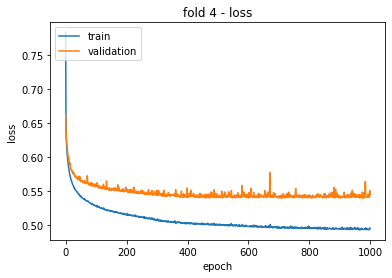

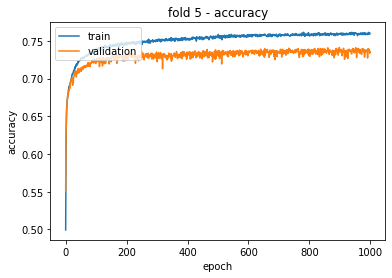

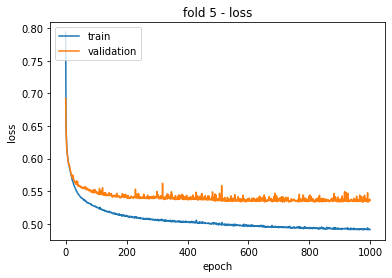

Fold accuracy: [0.7380895664602192, 0.7404407385348422, 0.7503275759380583, 0.7223347230494341, 0.7356759976176296]
Average accuracy: 0.7373737203200367
Selected Model accuracy: 0.7380895664602192

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_mlp.h5

Training time (sec): 1550.261310577

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_mlp.h5

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_mlp.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_mlp.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1] ...
Accuracy score             : 0.7336573279969506
F1-score                   : 0.7281921618204804
Precision 

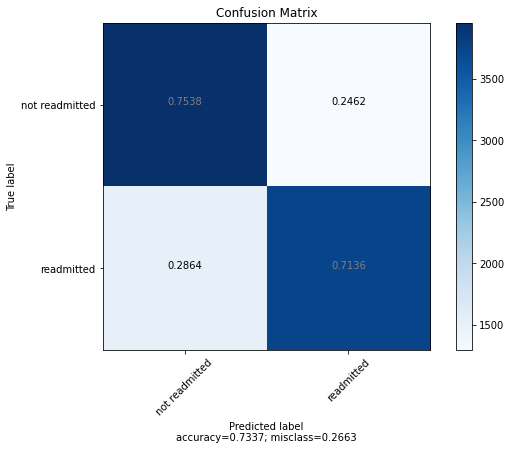

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='mlp')

## NN

Training
--------------------------------------------------------------------------------


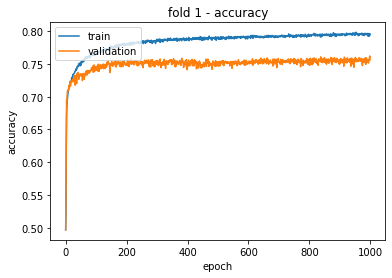

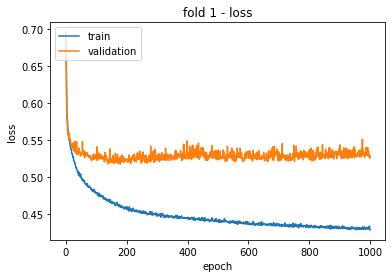

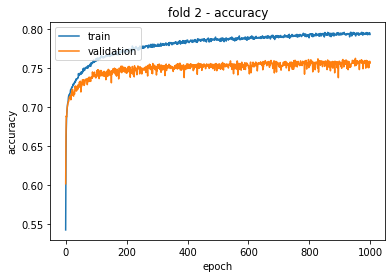

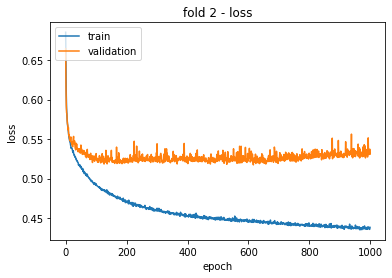

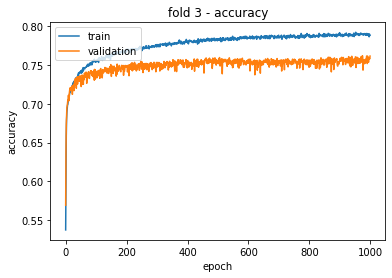

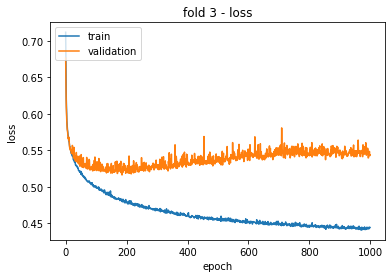

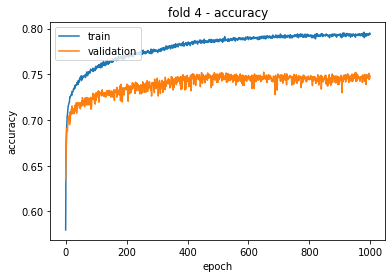

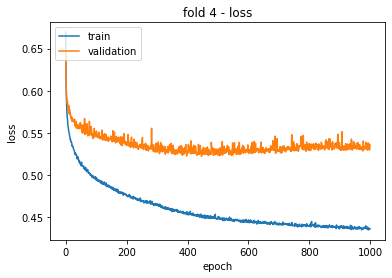

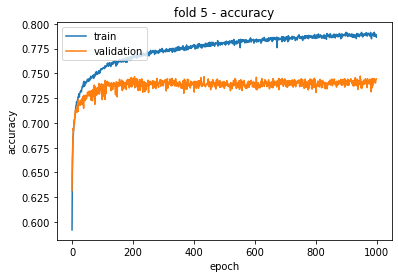

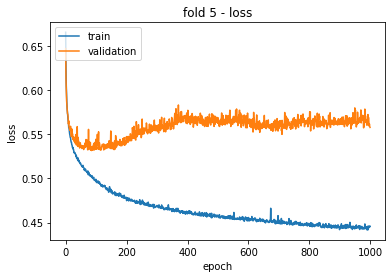

Fold accuracy: [0.7560743211052883, 0.7566408576533651, 0.7614055985705778, 0.7481834425253127, 0.7443716497915426]
Average accuracy: 0.7533351739292172
Selected Model accuracy: 0.7560743211052883

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_nn.h5

Training time (sec): 1506.320569992

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_nn.h5

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_nn.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_nn.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1] ...
Accuracy score             : 0.7562416619020392
F1-score                   : 0.7737884683409975
Precision scor

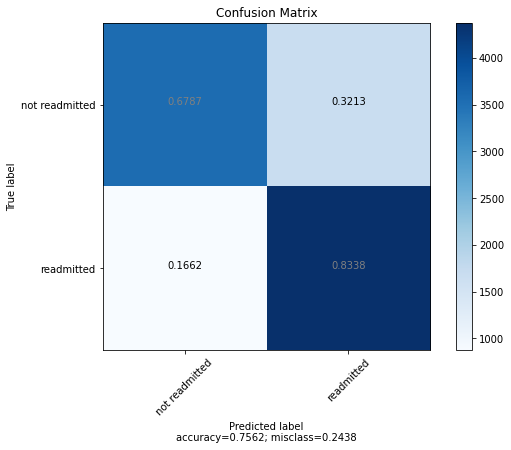

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote",model_type='nn')

# One-hot Encoded Data with SMOTE - Training and testing

## DT (run from here)

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.820271557884707, 0.8201310303752234, 0.8171530673019655, 0.8106015485407981, 0.820011911852293]
Average accuracy: 0.8176338231909975
Selected Model accuracy: 0.8171530673019655

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_dt.pkl

Training time (sec): 2.273209810

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_dt.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_dt.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_dt.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1] ...
Accuracy score     

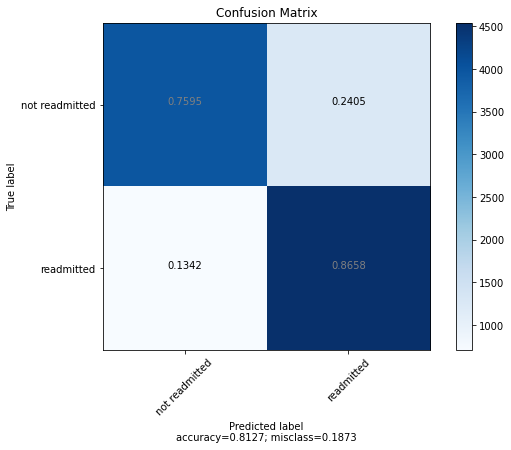

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='dt')

## RF

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8745831348261077, 0.8725431804645623, 0.8737343656938654, 0.8669446098868374, 0.8693269803454438]
Average accuracy: 0.8714264542433634
Selected Model accuracy: 0.8725431804645623

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_rf.pkl

Training time (sec): 27.830695391

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_rf.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_rf.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_rf.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accuracy score  

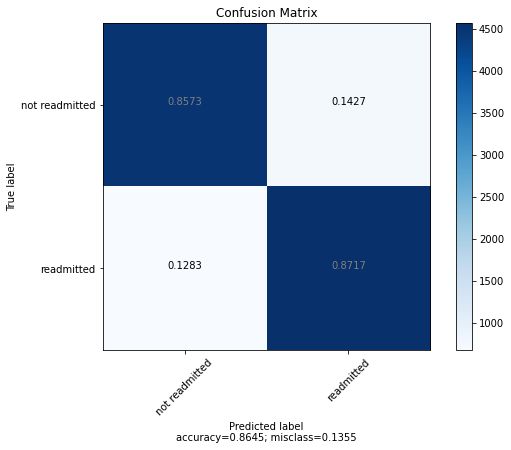

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='rf')

## KNN

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.7896617436874702, 0.7995235259082787, 0.8023823704586063, 0.7918999404407385, 0.792852888624181]
Average accuracy: 0.7952640938238549
Selected Model accuracy: 0.792852888624181

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_knn.pkl

Training time (sec): 325.907306910

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_knn.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_knn.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_knn.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] ...
Accuracy scor

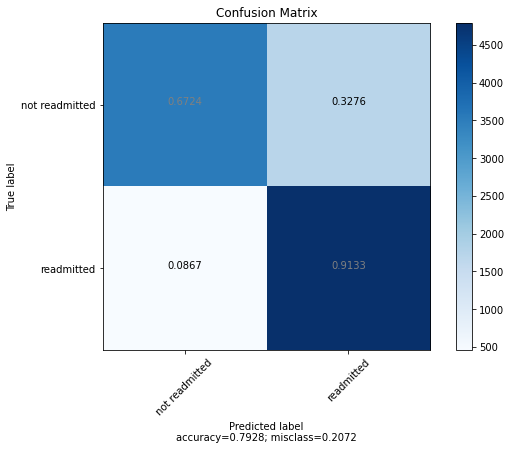

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='knn')

## NB

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.6929490233444497, 0.6993448481238833, 0.6972007147111375, 0.6927933293627159, 0.6931506849315069]
Average accuracy: 0.6950877200947386
Selected Model accuracy: 0.6931506849315069

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_nb.pkl

Training time (sec): 0.450461149

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_nb.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_nb.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_nb.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1] ...
Accuracy score   

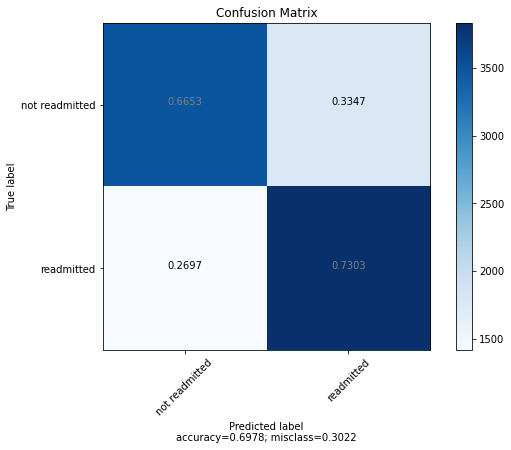

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='nb')

## LR

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.7354692710814673, 0.7355568790946992, 0.7365098272781417, 0.7220964860035736, 0.7317450863609292]
Average accuracy: 0.7322755099637621
Selected Model accuracy: 0.7317450863609292

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_lr.pkl

Training time (sec): 4.665264845

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_lr.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_lr.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_lr.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1] ...
Accuracy score   

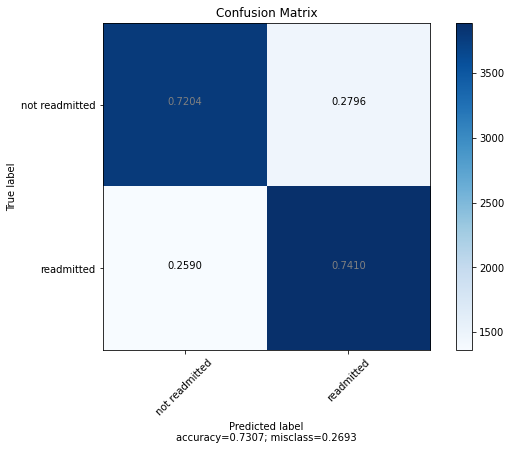

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='lr')

## LDA

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.7367794187708433, 0.7348421679571173, 0.7367480643240024, 0.7217391304347827, 0.7331745086360929]
Average accuracy: 0.7326566580245678
Selected Model accuracy: 0.7331745086360929

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_lda.pkl

Training time (sec): 4.394343615

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_lda.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_lda.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_lda.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1] ...
Accuracy scor

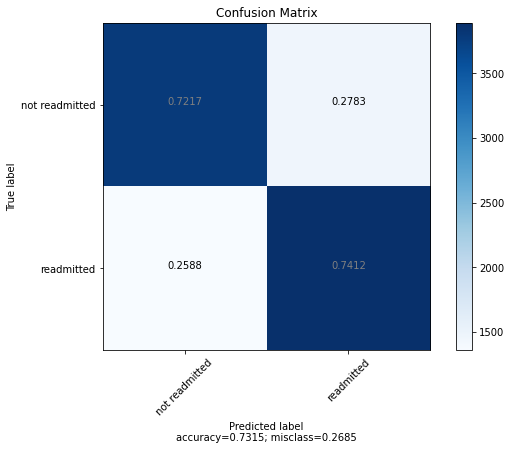

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='lda')

## QDA

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.5094092424964268, 0.5565217391304348, 0.5391304347826087, 0.5515187611673615, 0.5317450863609291]
Average accuracy: 0.5376650527875522
Selected Model accuracy: 0.5391304347826087

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_qda.pkl

Training time (sec): 3.027791023

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_qda.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_qda.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_qda.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1] ...
Accuracy scor

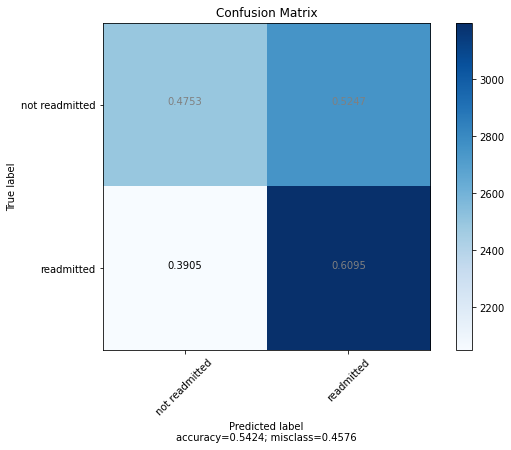

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='qda')

## SVM

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.7939494997617913, 0.8002382370458606, 0.8023823704586063, 0.789398451459202, 0.7942823108993449]
Average accuracy: 0.796050173924961
Selected Model accuracy: 0.7942823108993449

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_svm.pkl

Training time (sec): 1280.590208292

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_svm.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_svm.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_svm.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1] ...
Accuracy sco

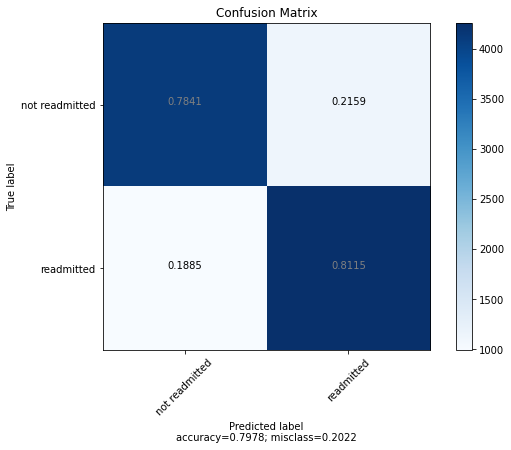

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='svm')

## MLP

Training
--------------------------------------------------------------------------------


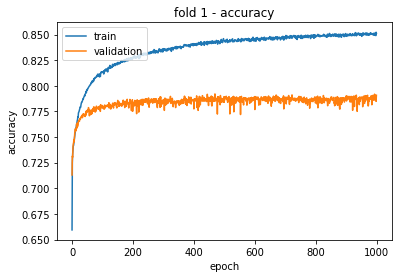

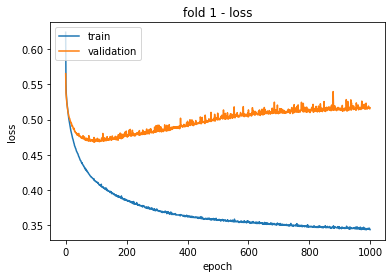

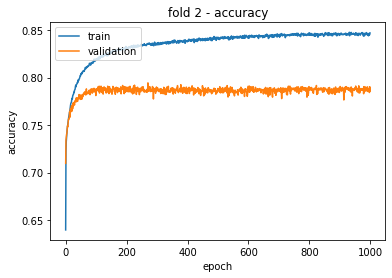

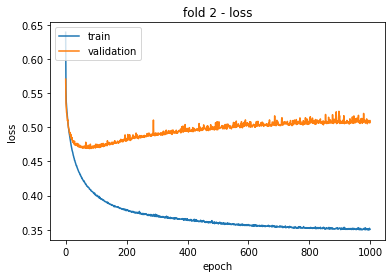

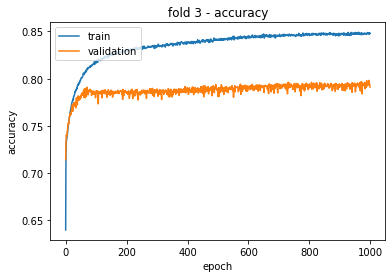

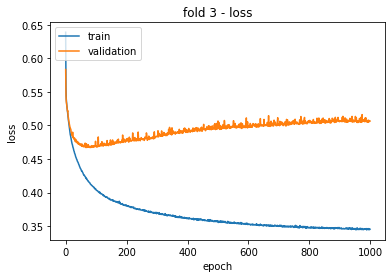

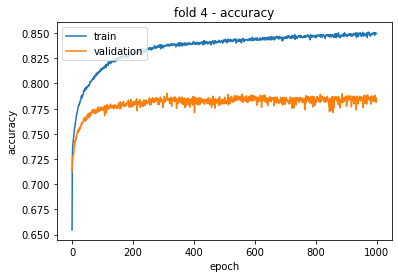

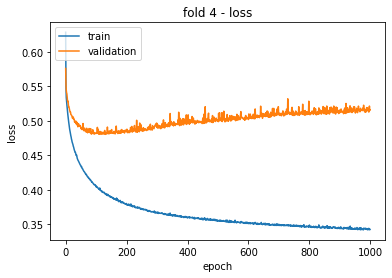

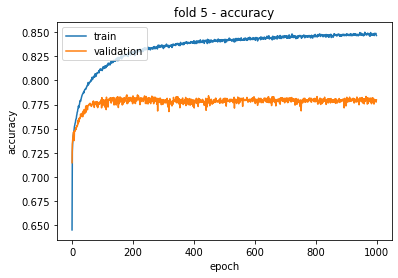

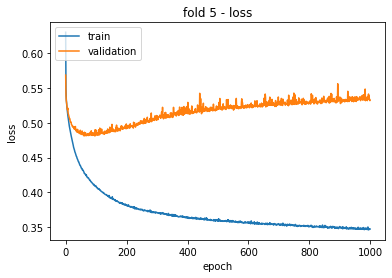

Fold accuracy: [0.7907336827060505, 0.7857057772483621, 0.7910661107802264, 0.7835616438356164, 0.7799880881477069]
Average accuracy: 0.7862110605435924
Selected Model accuracy: 0.7857057772483621

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_mlp.h5

Training time (sec): 1574.216627598

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_mlp.h5

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_mlp.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_mlp.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1] ...
Accuracy score             : 0.7870211549456833
F1-score                   : 0.7856526325884723
Precis

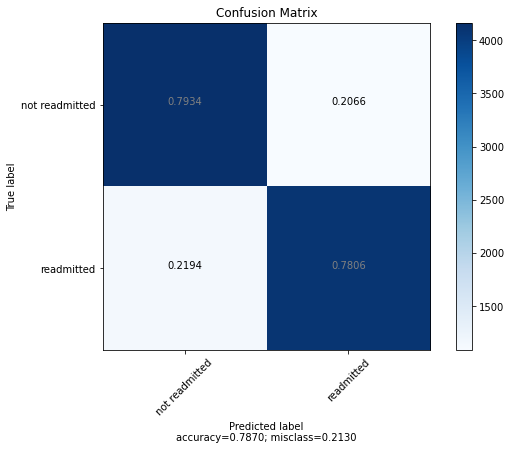

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='mlp')

## NN

Training
--------------------------------------------------------------------------------


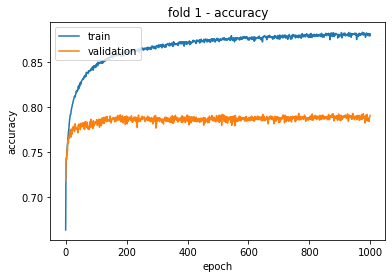

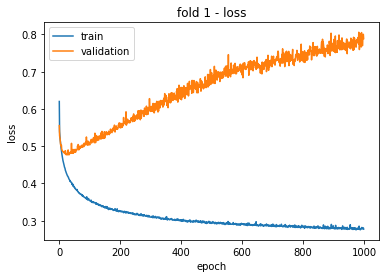

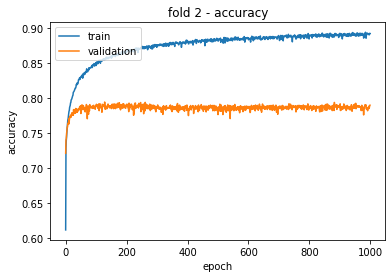

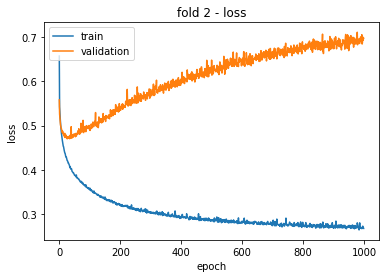

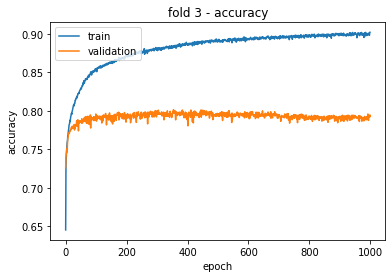

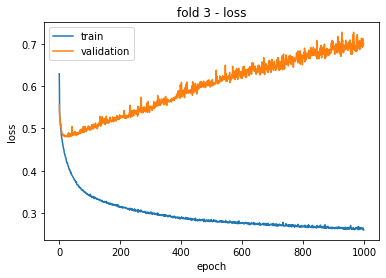

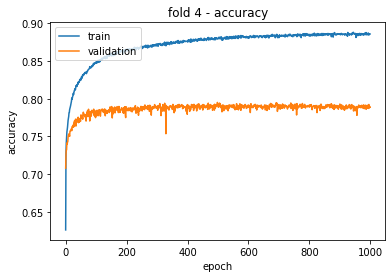

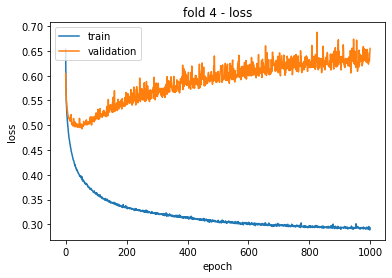

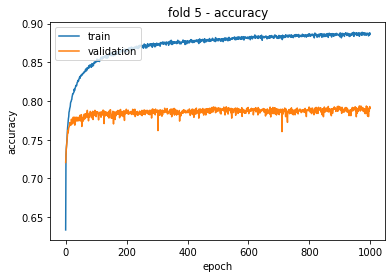

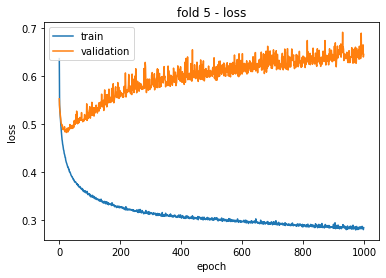

Fold accuracy: [0.7907336827060505, 0.7896366885050625, 0.7942823108993449, 0.7889219773674806, 0.7907087552114354]
Average accuracy: 0.7908566829378747
Selected Model accuracy: 0.7907336827060505

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_nn.h5

Training time (sec): 1614.881206036

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_ohe_smote_nn.h5

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_ohe_smote_nn.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_ohe_smote_nn.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1] ...
Accuracy score             : 0.7872117400419287
F1-score                   : 0.7892402076451156
Precision 

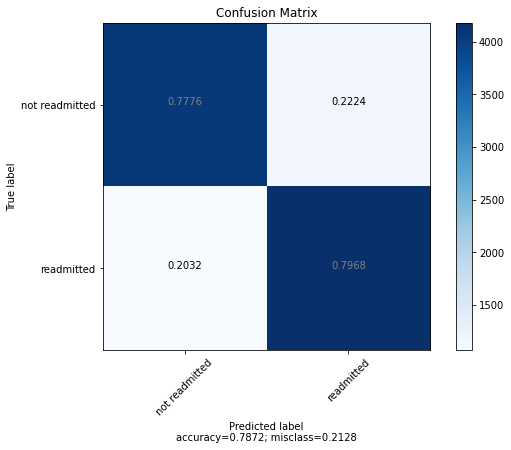

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_ohe_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_ohe_y_smote_train.npy")
X_test = np.load(save_path+"dataset_df_cat_ohe_X_smote_test.npy")
y_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="ohe_smote",model_type='nn')

# Feature Selection (Run from here)

## SFS - Forward (run from here)

In [ ]:
# use RF to select features
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
model = RandomForestClassifier(max_depth=None, random_state=0)

sfs = SFS(model, 
          k_features=int(X_train.shape[1]*0.8),   # select 80% feature columns
          forward=True, 
          floating=False, 
          verbose=2,
          scoring='accuracy',
          cv=5,                                 # cross validation
          n_jobs=-1)                            # run CV on all CPU cores

sfs = sfs.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished

[2021-08-09 02:37:44] Features: 1/28 -- score: 0.5907422973757888[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:  1.4min finished

[2021-08-09 02:39:08] Features: 2/28 -- score: 0.6083237912718868[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  1.5min finished

[2021-08-09 02:40:35] Features: 3/28 -- score: 0.6199733558139514[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.7min finished

[2021-08-09 02:42:18] Features: 4/28 -- score: 0.6352916743870489[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  2.3min finished



In [ ]:
print('Sequential Forward Selection (k={})'.format(int(X_train.shape[1]*0.8)))
print("Indices of selected features: {}".format(sfs.k_feature_idx_))
print('CV Score                    : {}'.format(sfs.k_score_))
feature_name = dataset_df_cat_le.columns.tolist()
feature_name_selected = [feature_name[idx] for idx in sfs.k_feature_idx_]
print("Selected features           : {}".format(feature_name_selected))

feature_idx_selected_by_sequence = []
feature_cv_avg_score = []
for _ in sfs.subsets_:
  # print(sfs.subsets_[_])
  for idx in sfs.subsets_[_]['feature_names']:
    if int(idx) not in feature_idx_selected_by_sequence:
      feature_idx_selected_by_sequence.append(int(idx))
      feature_cv_avg_score.append(sfs.subsets_[_]['avg_score'])

print("Feature indices selected by sequence               : {}".format(feature_idx_selected_by_sequence))
print("CV average score by current feature selection      : {}".format(feature_cv_avg_score))

# select only the features keep increasing the CV average score
target_idx = 0
for idx in range(len(feature_cv_avg_score)):
  if idx+1 == len(feature_cv_avg_score) or feature_cv_avg_score[idx+1] <= feature_cv_avg_score[idx]:
    target_idx = idx
    break

feature_idx_increase_cv_score =  feature_idx_selected_by_sequence[:idx+1]
print("The feature indices that increase CV average score : {}".format(feature_idx_increase_cv_score))
feature_name_increase_cv_score = [feature_name[idx] for idx in feature_idx_increase_cv_score]
print("The feature names that increase CV average score   : {}".format(feature_name_increase_cv_score))

Sequential Forward Selection (k=28)
Indices of selected features: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34)
CV Score                    : 0.8779539989121
Selected features           : ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'time_in_hospital_group', 'num_lab_procedures_group', 'num_procedures_group', 'num_medications_group', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin', 'change', 'diabetesMed', 'diag_250_cnt']
Feature indices selected by sequence               : [1, 11, 0, 6, 7, 2, 8, 3, 32, 10, 33, 30, 4, 5, 18, 12, 23, 28, 21, 9, 34, 19, 25, 17, 20, 27, 26, 24]
CV average score by current feature selection      : [0.5907422973757888, 0.6083237912718868, 0.6199733558139514, 0.6352916743870489, 0.6639032767808829, 0.7

## Save the Label Encoded Data with SMOTE by the selected feature columns

In [ ]:
# save the label encoded datasets with selected features
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"

dataset_df_cat_le_X_smote_sfs_train = dataset_df_cat_le_X_smote_train[:,feature_idx_increase_cv_score]
dataset_df_cat_le_y_smote_sfs_train = np.load(save_path+"dataset_df_cat_le_y_smote_train.npy")
dataset_df_cat_le_X_smote_sfs_test = dataset_df_cat_le_X_smote_test[:,feature_idx_increase_cv_score]
dataset_df_cat_le_y_smote_sfs_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")

np.save(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy",dataset_df_cat_le_X_smote_sfs_train)
np.save(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy",dataset_df_cat_le_y_smote_sfs_train)
np.save(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy",dataset_df_cat_le_X_smote_sfs_test)
np.save(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy",dataset_df_cat_le_y_smote_sfs_test)

# Label Encoded Data with SMOTE and SFS - Training and testing <font color='red'>**(Run From Here to Save time for SFS feature selection)**</font>

## DT (run from here)

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8307527393997142, 0.8247766527695056, 0.8232281119714115, 0.8212030970815962, 0.8183442525312686]
Average accuracy: 0.8236609707506993
Selected Model accuracy: 0.8232281119714115

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_dt.pkl

Training time (sec): 0.593694687

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_dt.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_dt.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_dt.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1] ...
Accur

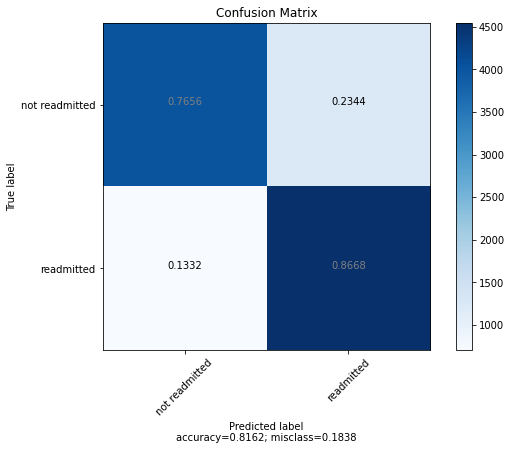

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='dt')

## RF

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8752977608384945, 0.8726622989874926, 0.8748064324002383, 0.8644431209053007, 0.8726622989874926]
Average accuracy: 0.8719743824238038
Selected Model accuracy: 0.8726622989874926

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_rf.pkl

Training time (sec): 15.209204912

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_rf.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_rf.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_rf.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accu

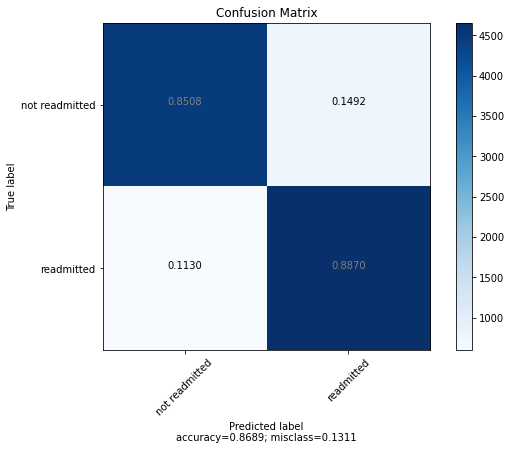

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='rf')

## KNN

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.8149118627918056, 0.8138177486599166, 0.813936867182847, 0.8145324597974986, 0.8052412150089339]
Average accuracy: 0.8124880306882003
Selected Model accuracy: 0.8138177486599166

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_knn.pkl

Training time (sec): 6.051600933

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_knn.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_knn.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_knn.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1] ...
Ac

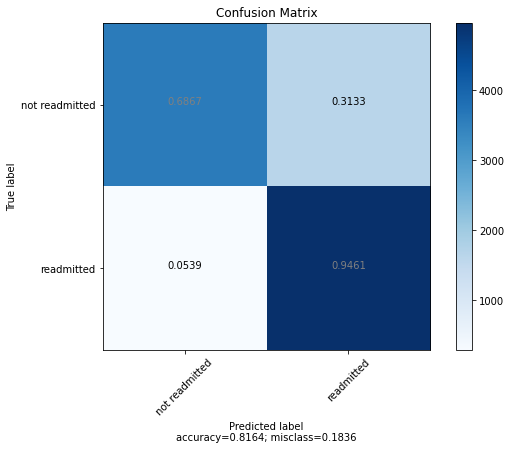

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='knn')

## NB

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.6132682229633158, 0.6171530673019655, 0.6109589041095891, 0.6110780226325193, 0.6145324597974985]
Average accuracy: 0.6133981353609776
Selected Model accuracy: 0.6132682229633158

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_nb.pkl

Training time (sec): 0.103712797

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_nb.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_nb.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_nb.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1] ...
Accur

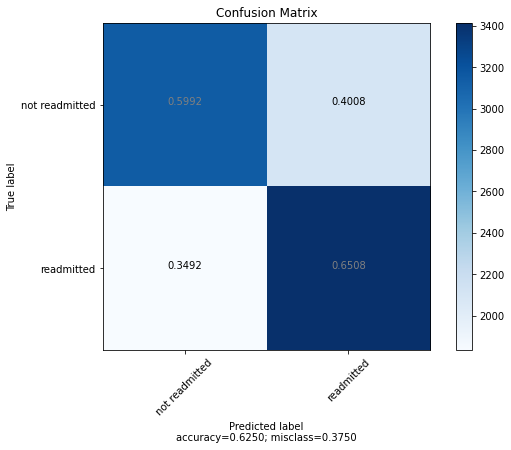

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='nb')

## LR

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.6692472606002858, 0.6677784395473496, 0.6614651578320428, 0.6531268612269208, 0.6650387135199524]
Average accuracy: 0.6633312865453103
Selected Model accuracy: 0.6650387135199524

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_lr.pkl

Training time (sec): 2.731968403

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_lr.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_lr.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_lr.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1] ...
Accur

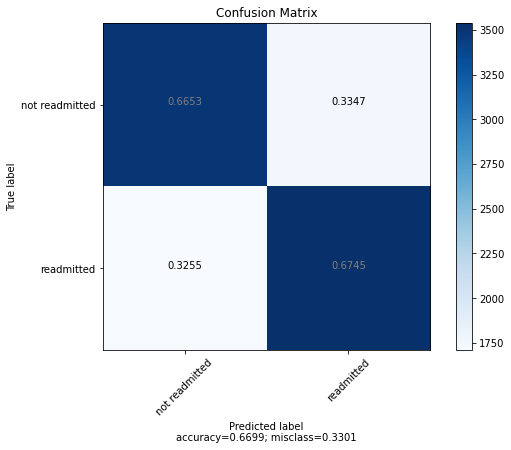

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='lr')

## LDA

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.668532634587899, 0.6670637284097677, 0.6606313281715307, 0.6519356759976176, 0.6662298987492555]
Average accuracy: 0.6628786531832142
Selected Model accuracy: 0.6606313281715307

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_lda.pkl

Training time (sec): 0.747050524

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_lda.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_lda.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_lda.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1] ...
Ac

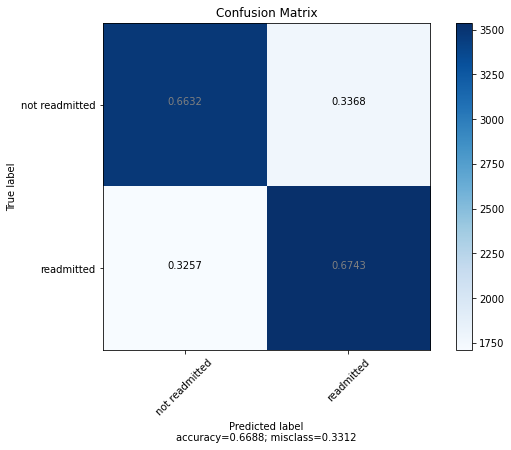

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='lda')

## QDA

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.633754168651739, 0.6329958308516974, 0.6318046456223942, 0.6309708159618821, 0.6371649791542585]
Average accuracy: 0.6333380880483942
Selected Model accuracy: 0.6329958308516974

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_qda.pkl

Training time (sec): 0.305401802

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_qda.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_qda.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_qda.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Ac

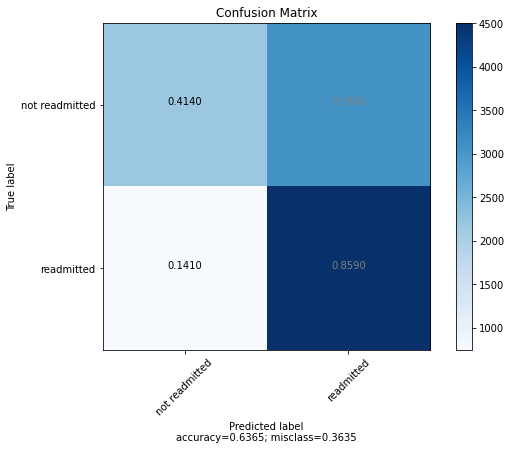

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='qda')

## SVM

Training
--------------------------------------------------------------------------------
Fold accuracy: [0.753692234397332, 0.7567599761762954, 0.7491363907087553, 0.737343656938654, 0.7465157832042882]
Average accuracy: 0.7486896082850649
Selected Model accuracy: 0.7491363907087553

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_svm.pkl

Training time (sec): 280.201474905

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_svm.pkl

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_svm.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_svm.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1] ...
A

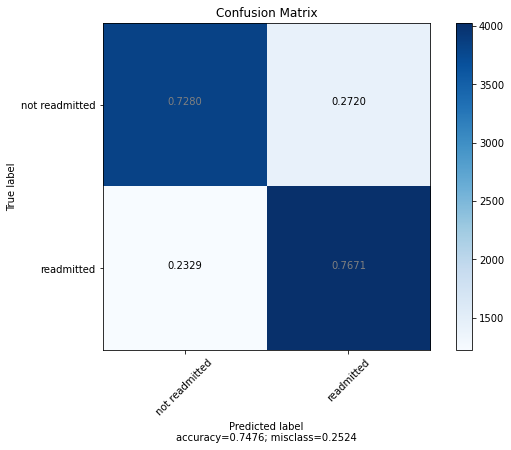

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='svm')

## MLP

Training
--------------------------------------------------------------------------------


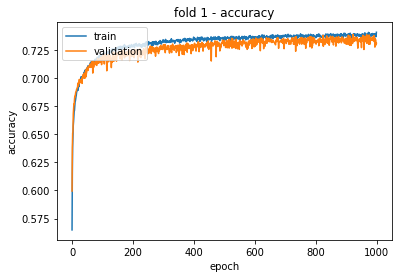

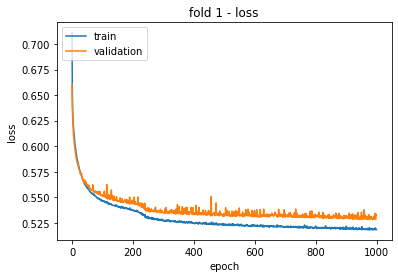

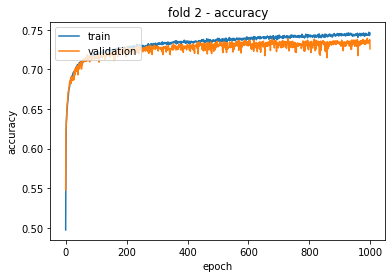

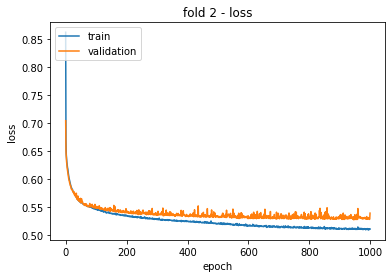

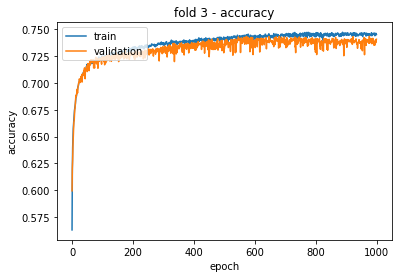

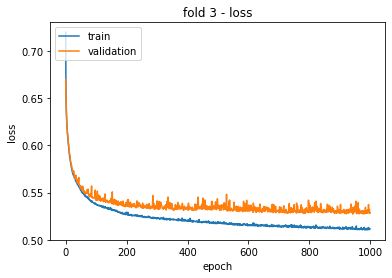

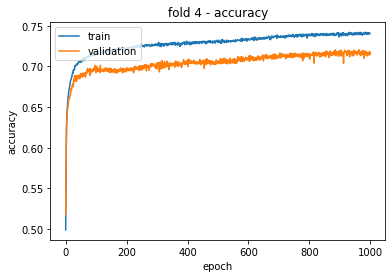

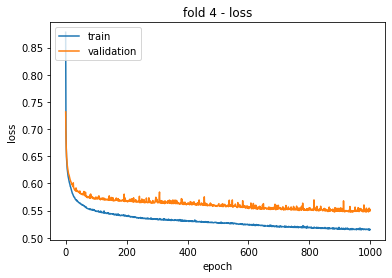

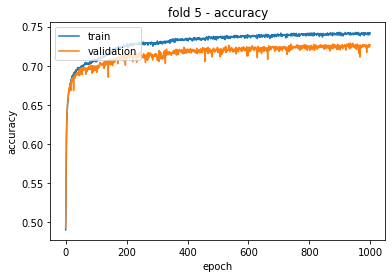

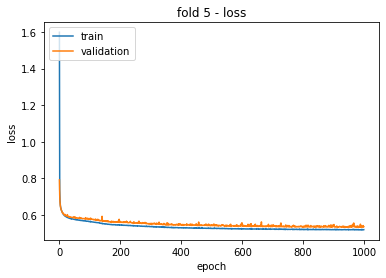

Fold accuracy: [0.7308242020009529, 0.7259082787373436, 0.7406789755807028, 0.7151876116736152, 0.7268612269207861]
Average accuracy: 0.7278920589826801
Selected Model accuracy: 0.7268612269207861

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_mlp.h5

Training time (sec): 1535.787651539

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_mlp.h5

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_mlp.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_mlp.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1] ...
Accuracy score             : 0.7291785782351821
F1-score                   : 0.74045662100

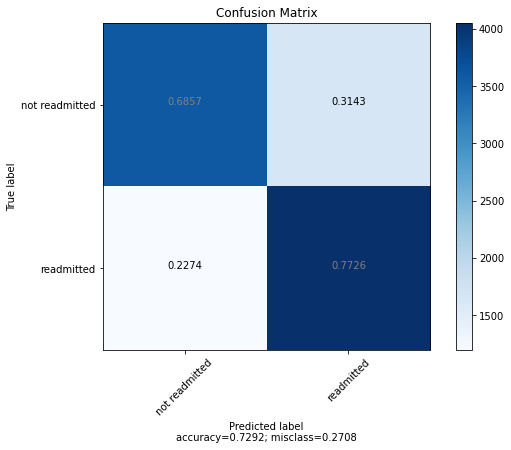

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='mlp')

## NN

Training
--------------------------------------------------------------------------------


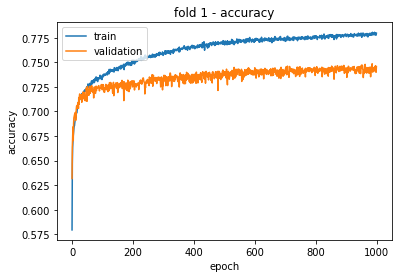

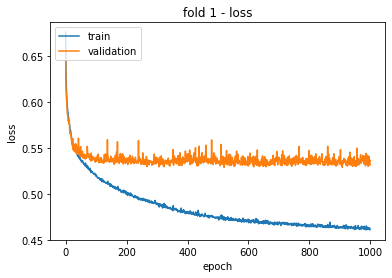

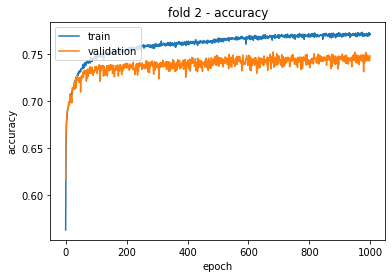

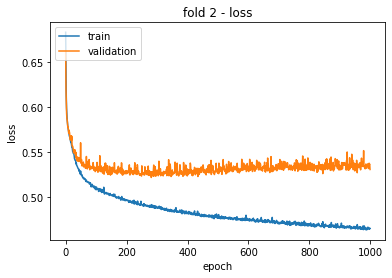

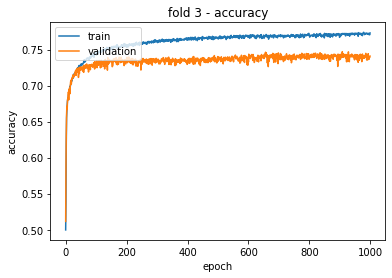

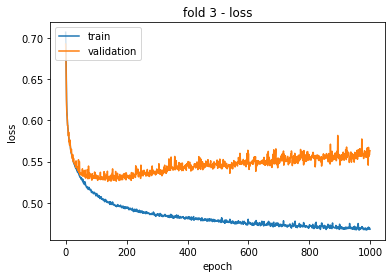

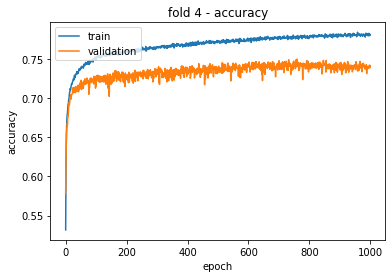

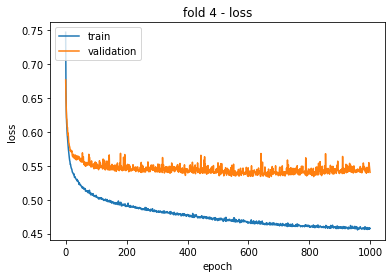

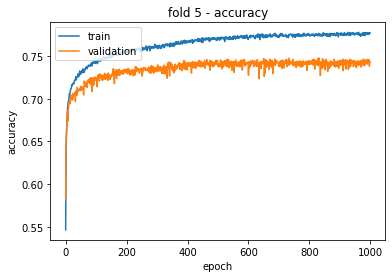

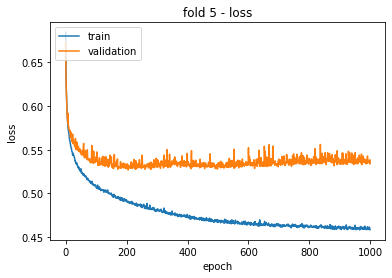

Fold accuracy: [0.7457122439256789, 0.7484216795711733, 0.7410363311494937, 0.7416319237641453, 0.7431804645622394]
Average accuracy: 0.7439965285945461
Selected Model accuracy: 0.7431804645622394

Model saved at /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_nn.h5

Training time (sec): 1565.093487263

Testing
--------------------------------------------------------------------------------

Model loaded from /content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/model_le_smote_sfs_nn.h5

/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/true_le_smote_sfs_nn.npy saved.
/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/pred_le_smote_sfs_nn.npy saved.
True       : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1] ...
Prediction : [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1] ...
Accuracy score             : 0.7413760243948924
F1-score                   : 0.745259996245541

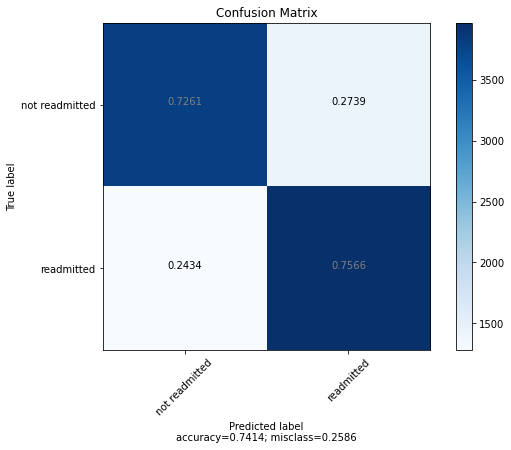

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
X_train = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_train.npy")
y_train = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_train.npy")
X_test = np.load(save_path+"dataset_df_cat_le_X_smote_sfs_test.npy")
y_test = np.load(save_path+"dataset_df_cat_le_y_smote_sfs_test.npy")

train_model(X_train,y_train,X_test,y_test,save_path=save_path,data_type="le_smote_sfs",model_type='nn')

# Ensemble for all classifiers (run from here)

Results:
--------------------------------------------------------------------------------
                                                Accuracy    F1-score   Precision      Recall Confusion Matrix 
Classifier # 1: le_smote_dt          Metrics:  0.8254241   0.8339677   0.7950579   0.8768820 4061.0000000 1186.0000000 646.0000000 4601.0000000 
Classifier # 2: le_smote_rf          Metrics:  0.8757385   0.8773745   0.8659736   0.8890795 4525.0000000 722.0000000 582.0000000 4665.0000000 
Classifier # 3: le_smote_knn         Metrics:  0.8128454   0.8351242   0.7462866   0.9479703 3556.0000000 1691.0000000 273.0000000 4974.0000000 
Classifier # 4: le_smote_nb          Metrics:  0.6284544   0.6401477   0.6206156   0.6609491 3127.0000000 2120.0000000 1779.0000000 3468.0000000 
Classifier # 5: le_smote_lr          Metrics:  0.6839146   0.6858604   0.6816642   0.6901086 3556.0000000 1691.0000000 1626.0000000 3621.0000000 
Classifier # 6: le_smote_lda         Metrics:  0.6828664   0.6843104   0.

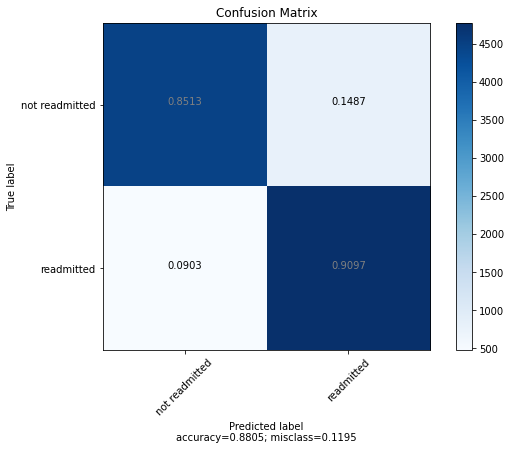

In [5]:
save_path = "/content/drive/MyDrive/Colab Notebooks/COMP5112_Research Methodology/"
metrics = os.listdir(save_path)

# select classifiers by thresholds
th_acc = 0.75
th_f1s = 0.75
clf_sel = []

print("Results:")
print("-"*80)
metrics_title = ['Accuracy','F1-score','Precision','Recall','Confusion Matrix']
print(" "*45,end="")
for m_t in metrics_title:
  print("{: >11} ".format(m_t),end="")
print()
# list label encoding classifiers
idx_clf = 0
for me in metrics:
  if "metric" in me:
    if "le" in me:    # model_le_smote_svm.pkl, true_le_smote_svm.npy, pred_le_smote_svm.npy, metric_le_smote_svm.npy
      idx_clf += 1
      clf_name = me[len("metric_"):len(me)-len(".npy")] 
      print("Classifier #{:2d}: {:20s} ".format(idx_clf, clf_name), end="")
      me_list = np.load(save_path+me)
      me_list = me_list.tolist()
      print("Metrics:",end="")
      for m_l in me_list:
        print("{: >11} ".format("{:4.7f}".format(m_l)),end="")
      print()

      # select the classifier if it meets thresholds
      if me_list[0]>=th_acc and me_list[1]>=th_f1s:
        clf_sel.append(clf_name)
# list one-hot encoding classifier
for me in metrics:
  if "metric" in me:
    if "ohe" in me:
      idx_clf += 1
      clf_name = me[len("metric_"):len(me)-len(".npy")] 
      print("Classifier #{:2d}: {:20s} ".format(idx_clf, clf_name), end="")
      me_list = np.load(save_path+me)
      me_list = me_list.tolist()
      print("Metrics:",end="")
      for m_l in me_list:
        print("{: >11} ".format("{:4.7f}".format(m_l)),end="")
      print()

      # select the classifier if it meets thresholds
      if me_list[0]>=th_acc and me_list[1]>=th_f1s:
        clf_sel.append(clf_name)

print("{} classifiers selected:{}\n".format(len(clf_sel),clf_sel))

# output the true and predictions of each selected classifier
for i in range(len(clf_sel)):
  print("classifier #{:2d}".format(i+1))
  print("True      :",np.load(save_path+"true_"+clf_sel[i]+".npy").astype(np.uint8).tolist())
  print("Prediction:",np.load(save_path+"pred_"+clf_sel[i]+".npy").astype(np.uint8).tolist())

# check whether the saved true values are the same as the original values
dataset_df_cat_le_y_smote_test = np.load(save_path+"dataset_df_cat_le_y_smote_test.npy")
dataset_df_cat_ohe_y_smote_test = np.load(save_path+"dataset_df_cat_ohe_y_smote_test.npy")

for i in range(len(list(dataset_df_cat_le_y_smote_test))):
  # check the onehot and label y values
  if list(dataset_df_cat_le_y_smote_test)[i] - list(dataset_df_cat_ohe_y_smote_test)[i] != 0:
    print(i,list(dataset_df_cat_le_y_smote_test)[i],list(dataset_df_cat_ohe_y_smote_test)[i])
    print("y values of label encoding does not match those of ont-hot encoding")
    break
  elif i==len(list(dataset_df_cat_le_y_smote_test))-1:
    print("y values of label encoding matches those of one-hot encoding")

# check whether each saved y values match the label encoding y values
for i in range(len(clf_sel)):
  true = np.load(save_path+"true_"+clf_sel[i]+".npy")
  for j in range(len(true)):
    if list(dataset_df_cat_le_y_smote_test)[j] - true.flatten()[j] !=0:
      print("y values of label encoding does not match those of saved y values for {}".format(clf_sel[i]))
      break
    elif j == len(true)-1:
      print("y values of label encoding match those of saved y vaues for {}".format(clf_sel[i]))  
    
# generate the prediction values by voting
pred = []
for i in range(len(clf_sel)):
  pred.append(np.load(save_path+"pred_"+clf_sel[i]+".npy").astype(np.uint8).tolist())
pred = np.array(pred)
pred_ensemble = []
for i in range(pred.shape[1]):
  if sum(pred[:,i])>=pred.shape[0]-sum(pred[:,i]):
    pred_ensemble.append(1)
  else:
    pred_ensemble.append(0)
true = np.load(save_path+"true_"+clf_sel[0]+".npy").astype(np.uint8).tolist()
print("True                :",true)
print("Prediction by voting:",pred_ensemble)

print("Accuracy score             :",accuracy_score(true, pred_ensemble))
print("F1-score                   :",f1_score(true, pred_ensemble))
print("Precision score            :",precision_score(true, pred_ensemble))
print("Recall score               :",recall_score(true, pred_ensemble))
print("Classification report      :\n",classification_report(true, pred_ensemble))
print("Confusion Matrix           :\n",confusion_matrix(true, pred_ensemble))

# plot confusion matrix
cm = confusion_matrix(true, pred_ensemble)
plot_confusion_matrix(cm, normalize = True, target_names = ["not readmitted","readmitted"], title = "Confusion Matrix")
